## Avocado price prediction

* Task type: Regression
* Models used: linear, support vector machine, decision tree, random forest regression, extreme gradient boost, k-nearest neighbors

Avocado is a fruit consumed by people heavily in the United States.
The table below represents weekly retail scan data for National retail volume (units) and price report from 4 January 2015 up to 17 May 2020. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.
The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Average Price (of avocados) is in US Dollars.
The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.
The data is already sorted by date and geographical names.


- Some relevant columns in the dataset:
    * date - The date of the observation
    * average_price - the average price of a single avocado (USD)
    * type - conventional or organic
    * year - the year
    * geography - the city or region of the observation
    * total_volume - Total number of PLU Hass avocados + total_bags sold
    * 4046 - Total number of avocados with PLU 4046 sold
    * 4225 - Total number of avocados with PLU 4225 sold
    * 4770 - Total number of avocados with PLU 4770 sold
    * total_bags - Total number of non-Hass avocados sold

## Size & Product Look Up (PLU) Code:
The most commonly sold sizes of fresh Hass avocado can be identified by their Product Lookup code or PLU or sticker. Avocados are also available for sale in netted bags. 

* Small/Medium Hass Avocado (~3-5oz avocado) | #4046

* Large Hass Avocado (~8-10oz avocado) | #4225

* Extra Large Hass Avocado (~10-15oz avocado) | #4770

* Hass Avocado Bags | Size varies: S, L, XL

#### A note on the data
The Total U.S. records under geography feature is somewhat aggregated for the following 8 geographical areas of the US: California, Great Lakes, Midsouth, Northeast, Plains, Southeast, South Central, and West. However, averaging data for these regions and areas does not result in the entries equal to those of the Total U.S. data

## Import Library and Initialize Global Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

SEED = 42

## Load CSV data

In [2]:
df = pd.read_csv('avocado-updated-2020.csv') # , parse_dates=['date']

df.head()

date  average_price  total_volume       4046       4225      4770  \
0  2015-01-04           1.22      40873.28    2819.50   28287.42     49.90   
1  2015-01-04           1.79       1373.95      57.42     153.88      0.00   
2  2015-01-04           1.00     435021.49  364302.39   23821.16     82.15   
3  2015-01-04           1.76       3846.69    1500.15     938.35      0.00   
4  2015-01-04           1.08     788025.06   53987.31  552906.04  39995.03   

   total_bags  small_bags  large_bags  xlarge_bags          type  year  \
0     9716.46     9186.93      529.53          0.0  conventional  2015   
1     1162.65     1162.65        0.00          0.0       organic  2015   
2    46815.79    16707.15    30108.64          0.0  conventional  2015   
3     1408.19     1071.35      336.84          0.0       organic  2015   
4   141136.68   137146.07     3990.61          0.0  conventional  2015   

              geography  
0                Albany  
1                Albany  
2               Atlanta  
3               Atlanta  
4  Baltimore/Washington

In [3]:
df.tail()

date  average_price  total_volume        4046       4225  \
33040  2020-11-29           1.47    1583056.27    67544.48   97996.46   
33041  2020-11-29           0.91    5811114.22  1352877.53  589061.83   
33042  2020-11-29           1.48     289961.27    13273.75   19341.09   
33043  2020-11-29           0.67     822818.75   234688.01   80205.15   
33044  2020-11-29           1.35      24106.58     1236.96     617.80   

           4770  total_bags  small_bags  large_bags  xlarge_bags  \
33040   2617.17  1414878.10   906711.52   480191.83     27974.75   
33041  19741.90  3790665.29  2197611.02  1531530.14     61524.13   
33042    636.51   256709.92   122606.21   134103.71         0.00   
33043  10543.63   497381.96   285764.11   210808.02       809.83   
33044   1564.98    20686.84    17824.52     2862.32         0.00   

               type  year            geography  
33040       organic  2020           Total U.S.  
33041  conventional  2020                 West  
33042       organic  2020                 West  
33043  conventional  2020  West Tex/New Mexico  
33044       organic  2020  West Tex/New Mexico

## Data Preprocessing

#### Create df1 to avoid editing raw data.

In [4]:
df1 = df.copy()

In [5]:
# Locate 'Total U.S.' from geography
locator = df1.loc[df1['geography'] == 'Total U.S.']
locator

date  average_price  total_volume         4046         4225  \
102    2015-01-04           0.95   31324277.73  12357161.34  13624083.05   
103    2015-01-04           1.46     612910.15    233286.13    216611.20   
210    2015-01-11           1.01   29063542.75  11544810.53  12134773.38   
211    2015-01-11           1.42     669528.88    270966.74    260971.60   
318    2015-01-18           1.03   29043458.85  11858139.34  11701947.80   
...           ...            ...           ...          ...          ...   
32824  2020-11-15           1.45    1816438.84     80685.29    125167.11   
32931  2020-11-22           0.89   41214193.33  11444048.13   7151354.88   
32932  2020-11-22           1.44    1739237.47     73434.15    103736.28   
33039  2020-11-29           0.89   36303871.76  10341275.25   6001923.10   
33040  2020-11-29           1.47    1583056.27     67544.48     97996.46   

            4770   total_bags   small_bags  large_bags  xlarge_bags  \
102    844093.32   4498940.02   3585321.58   894945.63     18672.81   
103      4370.99    158641.83    115068.71    43573.12         0.00   
210    866574.66   4517384.18   3783261.16   718333.87     15789.15   
211      3830.42    133760.12    106844.49    26915.63         0.00   
318    831301.90   4652069.81   3873041.26   771093.20      7935.35   
...          ...          ...          ...         ...          ...   
32824    3340.20   1607246.21   1039796.30   543194.91     24255.00   
32931  618593.03  21977641.34  14390924.72  6937432.89    649283.73   
32932    2931.90   1559135.14   1005969.89   520843.20     32322.05   
33039  530410.90  19371480.05  12667978.20  6230121.49    473380.36   
33040    2617.17   1414878.10    906711.52   480191.83     27974.75   

               type  year   geography  
102    conventional  2015  Total U.S.  
103         organic  2015  Total U.S.  
210    conventional  2015  Total U.S.  
211         organic  2015  Total U.S.  
318    conventional  2015  Total U.S.  
...             ...   ...         ...  
32824       organic  2020  Total U.S.  
32931  conventional  2020  Total U.S.  
32932       organic  2020  Total U.S.  
33039  conventional  2020  Total U.S.  
33040       organic  2020  Total U.S.  

[612 rows x 13 columns]

In [6]:
locator.index

Int64Index([  102,   103,   210,   211,   318,   319,   426,   427,   534,
              535,
            ...
            32607, 32608, 32715, 32716, 32823, 32824, 32931, 32932, 33039,
            33040],
           dtype='int64', length=612)

In [7]:
# Remove 'Total U.S.' from geography
df1 = df1.drop(locator.index)

In [8]:
# Verify dropped records
df1[df1['geography'] == 'Total U.S.']

Empty DataFrame
Columns: [date, average_price, total_volume, 4046, 4225, 4770, total_bags, small_bags, large_bags, xlarge_bags, type, year, geography]
Index: []

#### Add features

In [155]:
#Introducing new feature = 'season'


df1['date'] = pd.to_datetime(df1['date'])
df1['month'] = df1['date'].dt.month

# numeric
conditions = [(df1['month'].between(3,5,inclusive=True)),
           (df1['month'].between(6,8,inclusive=True)),
           (df1['month'].between(9,11,inclusive=True)),
           (df1['month'].between(1,2,inclusive=True)),
            (df1['month'] == 12)]

values_int = [0,1,2,3,3]
#spring = 0, summer = 1, fall = 2, winter = 3
df1['seasons_num'] = np.select(conditions, values_int)

# category
conditions1 = [(df1['seasons_num'] == 0), 
            (df1['seasons_num'] == 1), 
            (df1['seasons_num'] == 2), 
            (df1['seasons_num'] == 3)]

values = ['spring', 'summer', 'fall', 'winter']
#spring = 0, summer = 1, fall = 2, winter = 3
df1['seasons'] = np.select(conditions1, values)

##############################################################################################

#Introducing new feature = 'day'


df1['days'] = df1['date'].dt.day

##############################################################################################

#Introducing new feature = 'weekday'


# Monday is 0 and Sunday is 6
df1['weekdays'] = df1['date'].dt.weekday
df1['day_names'] = df1['date'].dt.strftime("%A") # df1['date'].dt.day_name()

#Introducing new feature = 'month_name'
df1['month_names'] = df1['date'].dt.strftime("%b")

In [157]:
df1.sample(5)

date  average_price  total_volume   PLU_4046    PLU_4225  \
25201 2019-07-14           1.50     187342.59   64045.72     7577.77   
9394  2016-08-28           1.69      13652.91    2630.75     2321.75   
23095 2019-02-24           1.09     118002.78   34944.96    35979.49   
771   2015-02-22           1.90       3180.29     198.13     1119.06   
13529 2017-05-28           1.37    3562841.46  580440.94  1365403.08   

        PLU_4770  total_bags  small_bags  large_bags  xlarge_bags  ...  \
25201     621.90   115097.20    35319.06    77092.81      2685.33  ...   
9394       11.34     8689.07     5137.77     3551.30         0.00  ...   
23095     122.31    46956.02    18846.75    27554.67       554.60  ...   
771       992.87      870.23      870.23        0.00         0.00  ...   
13529  269625.44  1347372.00   776304.50   523114.36     47953.14  ...   

                 geography  month seasons_num  seasons  days weekdays  \
25201         Jacksonville      7           1   summer    14        6   
9394   West Tex/New Mexico      8           1   summer    28        6   
23095              Spokane      2           3   winter    24        6   
771              Charlotte      2           3   winter    22        6   
13529          Great Lakes      5           0   spring    28        6   

       day_names            division   region month_names  
25201     Sunday      South Atlantic    South         Jul  
9394      Sunday  West South Central    South         Aug  
23095     Sunday             Pacific     West         Feb  
771       Sunday      South Atlantic    South         Feb  
13529     Sunday  East North Central  Midwest         May  

[5 rows x 22 columns]

In [10]:
df1.groupby(by='day_names').count()

date  average_price  total_volume   4046   4225   4770  \
day_names                                                            
Monday       318            318           318    318    318    318   
Sunday     32115          32115         32115  32115  32115  32115   

           total_bags  small_bags  large_bags  xlarge_bags   type   year  \
day_names                                                                  
Monday            318         318         318          318    318    318   
Sunday          32115       32115       32115        32115  32115  32115   

           geography  month  seasons_num  seasons   days  weekdays  
day_names                                                           
Monday           318    318          318      318    318       318  
Sunday         32115  32115        32115    32115  32115     32115

In [11]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = df1[df1.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [date, average_price, total_volume, 4046, 4225, 4770, total_bags, small_bags, large_bags, xlarge_bags, type, year, geography, month, seasons_num, seasons, days, weekdays, day_names]
Index: []


In [12]:
# Select duplicate rows except last occurrence based on all columns
duplicateRowsDF = df1[df1.duplicated(keep='last')]
print("Duplicate Rows except last occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except last occurrence based on all columns are :
Empty DataFrame
Columns: [date, average_price, total_volume, 4046, 4225, 4770, total_bags, small_bags, large_bags, xlarge_bags, type, year, geography, month, seasons_num, seasons, days, weekdays, day_names]
Index: []


In [13]:
# Select all duplicate rows based on one column
duplicateRowsDF = df1[df1.duplicated(['total_volume'])]
print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on a single column are:
            date  average_price  total_volume       4046       4225      4770  \
7857  2016-05-22           0.78     569349.05  157623.84  205497.08  20406.29   
8424  2016-07-03           1.43       3529.44      11.65     261.39      0.00   
8574  2016-07-10           1.90      13234.04    4462.78    4630.00      0.00   
9584  2016-09-11           2.19       7223.46    1512.68    5358.04      3.98   
10606 2016-11-20           1.37      19634.24    5461.76     130.12      0.00   
...          ...            ...           ...        ...        ...       ...   
30300 2020-06-07           1.19      14563.00     119.00       0.00      0.00   
30314 2020-06-07           1.42      20021.00      25.00    2168.00      9.00   
30736 2020-07-05           1.36      29584.31    2342.02    1005.60      0.00   
31286 2020-08-09           1.47      18717.08       1.34    1915.84     12.02   
32800 2020-11-15           1.31      13069.87      21.00    1359

In [14]:
# Select all duplicate rows based on multiple column names in list
duplicateRowsDF = df1[df1.duplicated(['average_price', 'total_volume'])]
print("Duplicate Rows based on 2 columns are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on 2 columns are:
            date  average_price  total_volume        4046        4225  \
16953 2018-01-01           1.47     113514.42     2622.70   101135.53   
16954 2018-01-01           1.46       3463.85       18.12      198.16   
16955 2018-01-01           0.95     649352.59   341061.46    41818.27   
16956 2018-01-01           1.28      17217.91      331.16     3474.30   
16957 2018-01-01           1.15     849487.62    66628.66   519460.20   
...          ...            ...           ...         ...         ...   
17057 2018-01-01           0.94    6330634.55  1789024.92  2089553.44   
17058 2018-01-01           1.48     229477.07    26883.07    53165.30   
17059 2018-01-01           0.89     727024.03   347248.16   158559.97   
17060 2018-01-01           1.62      16552.71     1909.33     3538.48   
30300 2020-06-07           1.19      14563.00      119.00        0.00   

           4770  total_bags  small_bags  large_bags  xlarge_bags  \
16953     20.25 

In [15]:
duplicateRowsDF.sort_values(by='date').head()

date  average_price  total_volume       4046       4225     4770  \
16953 2018-01-01           1.47     113514.42    2622.70  101135.53    20.25   
17030 2018-01-01           1.39      13838.29     496.98    2962.71    94.76   
17029 2018-01-01           0.83     315463.87  101602.77  102532.75  1995.65   
17028 2018-01-01           2.06      13531.12      89.40    5189.69   203.49   
17027 2018-01-01           0.92     419590.58   90432.19  134861.05  5994.91   

       total_bags  small_bags  large_bags  xlarge_bags          type  year  \
16953     9735.94     5556.98     4178.96         0.00  conventional  2018   
17030    10283.84     9802.71      481.13         0.00       organic  2018   
17029   109332.70    97601.86    11720.60        10.24  conventional  2018   
17028     8048.54     7934.12      114.42         0.00       organic  2018   
17027   188302.43   178330.99     9970.33         1.11  conventional  2018   

                geography  month  seasons_num seasons  days  weekdays  \
16953              Albany      1            3  winter     1         0   
17030    Richmond/Norfolk      1            3  winter     1         0   
17029    Richmond/Norfolk      1            3  winter     1         0   
17028  Raleigh/Greensboro      1            3  winter     1         0   
17027  Raleigh/Greensboro      1            3  winter     1         0   

      day_names  
16953    Monday  
17030    Monday  
17029    Monday  
17028    Monday  
17027    Monday

In [16]:
duplicateRowsDF.index

Int64Index([16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961,
            16962,
            ...
            17050, 17051, 17052, 17053, 17054, 17057, 17058, 17059, 17060,
            30300],
           dtype='int64', length=107)

In [17]:
# Remove '2018-01-01' from date
df1 = df1.drop(duplicateRowsDF.index)

In [18]:
# Verify dropped records
df1[df1['date'] == '2018-01-01']

Empty DataFrame
Columns: [date, average_price, total_volume, 4046, 4225, 4770, total_bags, small_bags, large_bags, xlarge_bags, type, year, geography, month, seasons_num, seasons, days, weekdays, day_names]
Index: []

In [19]:
df1.groupby(by='day_names').count()

date  average_price  total_volume   4046   4225   4770  \
day_names                                                            
Monday       212            212           212    212    212    212   
Sunday     32114          32114         32114  32114  32114  32114   

           total_bags  small_bags  large_bags  xlarge_bags   type   year  \
day_names                                                                  
Monday            212         212         212          212    212    212   
Sunday          32114       32114       32114        32114  32114  32114   

           geography  month  seasons_num  seasons   days  weekdays  
day_names                                                           
Monday           212    212          212      212    212       212  
Sunday         32114  32114        32114    32114  32114     32114

In [20]:
df1[['geography','total_volume','average_price']]

geography  total_volume  average_price
0                    Albany      40873.28           1.22
1                    Albany       1373.95           1.79
2                   Atlanta     435021.49           1.00
3                   Atlanta       3846.69           1.76
4      Baltimore/Washington     788025.06           1.08
...                     ...           ...            ...
33038                 Tampa      11883.88           0.95
33041                  West    5811114.22           0.91
33042                  West     289961.27           1.48
33043   West Tex/New Mexico     822818.75           0.67
33044   West Tex/New Mexico      24106.58           1.35

[32326 rows x 3 columns]

In [21]:
# Introducing new feature = 'division'


division_from_USA = {
    'Hartford/Springfield': 'New England',
    'Northern New England': 'New England',
    'Boston': 'New England',
    'Pittsburgh': 'Mid-Atlantic',
    'Syracuse': 'Mid-Atlantic',
    'Buffalo/Rochester': 'Mid-Atlantic',
    'Albany': 'Mid-Atlantic',
    'Northeast': 'Mid-Atlantic',
    'Harrisburg/Scranton': 'Mid-Atlantic',
    'New York': 'Mid-Atlantic',
    'Philadelphia': 'Mid-Atlantic',
    'Grand Rapids': 'East North Central',
    'Indianapolis': 'East North Central',
    'Detroit': 'East North Central',
    'Great Lakes': 'East North Central',
    'Cincinnati/Dayton': 'East North Central',
    'Columbus': 'East North Central',
    'Chicago': 'East North Central',
    'St. Louis': 'West North Central',
    'Plains': 'West North Central',
    'Orlando': 'South Atlantic',
    'Atlanta': 'South Atlantic',
    'Charlotte': 'South Atlantic',
    'Roanoke': 'South Atlantic',
    'Raleigh/Greensboro': 'South Atlantic',
    'South Carolina': 'South Atlantic',
    'Richmond/Norfolk': 'South Atlantic',
    'Miami/Ft. Lauderdale': 'South Atlantic',
    'Jacksonville': 'South Atlantic',
    'Tampa': 'South Atlantic',
    'South Central': 'South Atlantic',
    'Southeast': 'East South Central',
    'Nashville': 'East South Central',
    'Louisville': 'East South Central',
    'Midsouth': 'East South Central',
    'Dallas/Ft. Worth': 'West South Central',
    'New Orleans/Mobile': 'West South Central',
    'Houston': 'West South Central',
    'West Tex/New Mexico': 'West South Central',
    'Boise': 'Mountain',
    'Denver': 'Mountain',
    'Las Vegas': 'Mountain',
    'West': 'Mountain',
    'Phoenix/Tucson': 'Mountain',
    'Los Angeles': 'Pacific',
    'California': 'Pacific',
    'San Francisco': 'Pacific',
    'Spokane': 'Pacific',
    'Seattle': 'Pacific',
    'Baltimore/Washington': 'Pacific',
    'San Diego': 'Pacific',
    'Sacramento': 'Pacific',
    'Portland': 'Pacific'
}
df1['division'] = df1['geography'].apply(lambda x : division_from_USA[x])



# Introducing new feature = 'region'


region_from_USA = {
    'New England': 'Northeast', 
    'Mid-Atlantic': 'Northeast',
    'East North Central': 'Midwest',
    'West North Central': 'Midwest', 
    'South Atlantic': 'South',
    'East South Central': 'South',
    'West South Central': 'South',
    'Mountain': 'West',
    'Pacific': 'West'
}
df1['region'] = df1['division'].apply(lambda x : region_from_USA[x])

In [22]:
df1.sample(5)

date  average_price  total_volume       4046       4225  \
20145 2018-07-22           1.40     572080.56   27243.77  471787.11   
27797 2019-12-29           0.96    2980914.62  715462.42   69844.92   
22641 2019-01-27           1.21     670256.04   75869.84  265855.43   
6901  2016-03-20           1.24      72560.52     784.13   46256.94   
21556 2018-10-21           1.35      30619.75    2931.45    3208.11   

            4770  total_bags  small_bags  large_bags  xlarge_bags  ...  year  \
20145     471.43    72578.25    32328.50    39786.42       463.33  ...  2018   
27797  186661.91  2008945.37  1134739.55   553064.69    321141.13  ...  2019   
22641   20484.40   308046.37   114038.48   193471.43       536.46  ...  2019   
6901       10.73    25508.72    25508.72        0.00         0.00  ...  2016   
21556       0.00    24480.19    24433.89       46.30         0.00  ...  2018   

                  geography month  seasons_num  seasons days  weekdays  \
20145  Northern New England     7            1   summer   22         6   
27797           Los Angeles    12            3   winter   29         6   
22641              Portland     1            3   winter   27         6   
6901               Syracuse     3            0   spring   20         6   
21556        Phoenix/Tucson    10            2     fall   21         6   

       day_names      division     region  
20145     Sunday   New England  Northeast  
27797     Sunday       Pacific       West  
22641     Sunday       Pacific       West  
6901      Sunday  Mid-Atlantic  Northeast  
21556     Sunday      Mountain       West  

[5 rows x 21 columns]

In [23]:
df1.rename(columns= {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}, inplace=True)

In [24]:
df1.describe()

average_price  total_volume      PLU_4046      PLU_4225       PLU_4770  \
count   32326.000000  3.232600e+04  3.232600e+04  3.232600e+04   32326.000000   
mean        1.381324  6.138198e+05  1.893348e+05  1.787349e+05   13687.326142   
std         0.380525  1.378748e+06  5.127632e+05  4.521708e+05   47301.404261   
min         0.440000  8.456000e+01  0.000000e+00  0.000000e+00       0.000000   
25%         1.100000  1.466471e+04  7.280475e+02  2.620430e+03       0.000000   
50%         1.350000  1.212911e+05  9.912755e+03  2.185728e+04     155.520000   
75%         1.620000  4.665239e+05  1.107750e+05  1.187313e+05    4629.972500   
max         3.250000  1.132468e+07  5.160897e+06  6.533193e+06  804558.250000   

         total_bags    small_bags    large_bags    xlarge_bags          year  \
count  3.232600e+04  3.232600e+04  3.232600e+04   32326.000000  32326.000000   
mean   2.320106e+05  1.590956e+05  6.798828e+04    4926.733651   2017.459042   
std    5.685057e+05  3.725497e+05  2.226697e+05   25161.950547      1.702219   
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000   2015.000000   
25%    8.874438e+03  6.217365e+03  4.296600e+02       0.000000   2016.000000   
50%    5.075762e+04  3.454341e+04  5.902095e+03       0.000000   2017.000000   
75%    1.622691e+05  1.138225e+05  3.657164e+04     728.190000   2019.000000   
max    6.523470e+06  4.017035e+06  3.533282e+06  730833.290000   2020.000000   

              month   seasons_num          days      weekdays  
count  32326.000000  32326.000000  32326.000000  32326.000000  
mean       6.390027      1.445895     15.577244      5.960651  
std        3.376295      1.106444      8.808276      0.484307  
min        1.000000      0.000000      1.000000      0.000000  
25%        3.000000      0.000000      8.000000      6.000000  
50%        6.000000      1.000000     15.000000      6.000000  
75%        9.000000      2.000000     23.000000      6.000000  
max       12.000000      3.000000     31.000000      6.000000

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32326 entries, 0 to 33044
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           32326 non-null  datetime64[ns]
 1   average_price  32326 non-null  float64       
 2   total_volume   32326 non-null  float64       
 3   PLU_4046       32326 non-null  float64       
 4   PLU_4225       32326 non-null  float64       
 5   PLU_4770       32326 non-null  float64       
 6   total_bags     32326 non-null  float64       
 7   small_bags     32326 non-null  float64       
 8   large_bags     32326 non-null  float64       
 9   xlarge_bags    32326 non-null  float64       
 10  type           32326 non-null  object        
 11  year           32326 non-null  int64         
 12  geography      32326 non-null  object        
 13  month          32326 non-null  int64         
 14  seasons_num    32326 non-null  int32         
 15  seasons        3232

In [26]:
df1.shape

(32326, 21)

In [27]:
df1.isna().sum()

date             0
average_price    0
total_volume     0
PLU_4046         0
PLU_4225         0
PLU_4770         0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
month            0
seasons_num      0
seasons          0
days             0
weekdays         0
day_names        0
division         0
region           0
dtype: int64

## Exploratory Data Analysis (EDA)

#### Verify features of df1 between numerical and categorical.

In [29]:
# limit to categorical data using df.select_dtypes()
df1_cat = df1.select_dtypes(include=['object'])

# limit to numerical data using df.select_dtypes()
df1_num = df1.select_dtypes(include=['number'])

# count number of unique numerical per column
df1_num.nunique()

average_price      260
total_volume     32291
PLU_4046         31017
PLU_4225         31676
PLU_4770         20153
total_bags       32141
small_bags       31327
large_bags       27779
xlarge_bags      11435
year                 6
month               12
seasons_num          4
days                31
weekdays             2
dtype: int64

In [30]:
# count number of unique category per column
df1_cat.nunique()

type          2
geography    53
seasons       4
day_names     2
division      9
region        4
dtype: int64

In [31]:
# total count of items for each unique category feature
df1_cat['type'].value_counts()

conventional    16165
organic         16161
Name: type, dtype: int64

In [32]:
df1_cat['geography'].value_counts()

Midsouth                610
New York                610
California              610
Dallas/Ft. Worth        610
Detroit                 610
Nashville               610
Louisville              610
Houston                 610
Los Angeles             610
Sacramento              610
Hartford/Springfield    610
Denver                  610
South Carolina          610
New Orleans/Mobile      610
Northeast               610
Albany                  610
Grand Rapids            610
Las Vegas               610
Spokane                 610
Syracuse                610
Roanoke                 610
Chicago                 610
Southeast               610
Plains                  610
Buffalo/Rochester       610
Harrisburg/Scranton     610
Pittsburgh              610
Boise                   610
Atlanta                 610
Philadelphia            610
Miami/Ft. Lauderdale    610
Raleigh/Greensboro      610
San Francisco           610
Great Lakes             610
Northern New England    610
West                

In [33]:
df1_cat['division'].value_counts()

South Atlantic        6709
Pacific               5490
Mid-Atlantic          4880
East North Central    4270
Mountain              3050
East South Central    2440
West South Central    2437
New England           1830
West North Central    1220
Name: division, dtype: int64

In [34]:
df1_cat['seasons'].value_counts()

spring    8480
fall      8268
summer    8265
winter    7313
Name: seasons, dtype: int64

In [35]:
df1_cat['region'].value_counts()

South        11586
West          8540
Northeast     6710
Midwest       5490
Name: region, dtype: int64

In [36]:
l_price = df1.loc[df1['average_price'].nlargest().index]
l_price

date  average_price  total_volume  PLU_4046  PLU_4225  PLU_4770  \
10344 2016-10-30           3.25      16700.94   2325.93  11142.85      0.00   
12952 2017-04-16           3.17       3018.56   1255.55     82.31      0.00   
10452 2016-11-06           3.12      19043.80   5898.49  10039.34      0.00   
12360 2017-03-12           3.05       2068.26   1043.83     77.36      0.00   
14976 2017-08-27           3.04      12656.32    419.06   4851.90    145.09   

       total_bags  small_bags  large_bags  xlarge_bags  ...  year  \
10344     3232.16     3232.16        0.00          0.0  ...  2016   
12952     1680.70     1542.22      138.48          0.0  ...  2017   
10452     3105.97     3079.30       26.67          0.0  ...  2016   
12360      947.07      926.67       20.40          0.0  ...  2017   
14976     7240.27     6960.97      279.30          0.0  ...  2017   

                  geography month  seasons_num  seasons days  weekdays  \
10344         San Francisco    10            2     fall   30         6   
12952                 Tampa     4            0   spring   16         6   
10452         San Francisco    11            2     fall    6         6   
12360  Miami/Ft. Lauderdale     3            0   spring   12         6   
14976    Raleigh/Greensboro     8            1   summer   27         6   

       day_names        division region  
10344     Sunday         Pacific   West  
12952     Sunday  South Atlantic  South  
10452     Sunday         Pacific   West  
12360     Sunday  South Atlantic  South  
14976     Sunday  South Atlantic  South  

[5 rows x 21 columns]

In [37]:
s_price = df1.loc[df1['average_price'].nsmallest().index]
s_price

date  average_price  total_volume    PLU_4046   PLU_4225  \
12222 2017-03-05           0.44      64057.04      223.84    4748.88   
11837 2017-02-05           0.46    2200550.27  1200632.86  531226.65   
12230 2017-03-05           0.48      50890.73      717.57    4138.84   
5573  2015-12-27           0.49    1137707.43   738314.80  286858.37   
12114 2017-02-26           0.49      44024.03      252.79    4472.68   

       PLU_4770  total_bags  small_bags  large_bags  xlarge_bags  ...  year  \
12222      0.00    59084.32      638.68    58445.64         0.00  ...  2017   
11837  18324.93   450365.83   113752.17   330583.10      6030.56  ...  2017   
12230      0.00    46034.32     1385.06    44649.26         0.00  ...  2017   
5573   11642.46   100891.80    70749.02    30142.78         0.00  ...  2015   
12114      0.00    39298.56      600.00    38698.56         0.00  ...  2017   

               geography month  seasons_num  seasons days  weekdays  \
12222  Cincinnati/Dayton     3            0   spring    5         6   
11837     Phoenix/Tucson     2            3   winter    5         6   
12230            Detroit     3            0   spring    5         6   
5573      Phoenix/Tucson    12            3   winter   27         6   
12114  Cincinnati/Dayton     2            3   winter   26         6   

       day_names            division   region  
12222     Sunday  East North Central  Midwest  
11837     Sunday            Mountain     West  
12230     Sunday  East North Central  Midwest  
5573      Sunday            Mountain     West  
12114     Sunday  East North Central  Midwest  

[5 rows x 21 columns]

In [38]:
print('Largest Average Price and Geography : \n', l_price[['average_price','geography']])
print()
print('Smallest Average Price and Geography : \n', s_price[['average_price','geography']])

Largest Average Price and Geography : 
        average_price             geography
10344           3.25         San Francisco
12952           3.17                 Tampa
10452           3.12         San Francisco
12360           3.05  Miami/Ft. Lauderdale
14976           3.04    Raleigh/Greensboro

Smallest Average Price and Geography : 
        average_price          geography
12222           0.44  Cincinnati/Dayton
11837           0.46     Phoenix/Tucson
12230           0.48            Detroit
5573            0.49     Phoenix/Tucson
12114           0.49  Cincinnati/Dayton


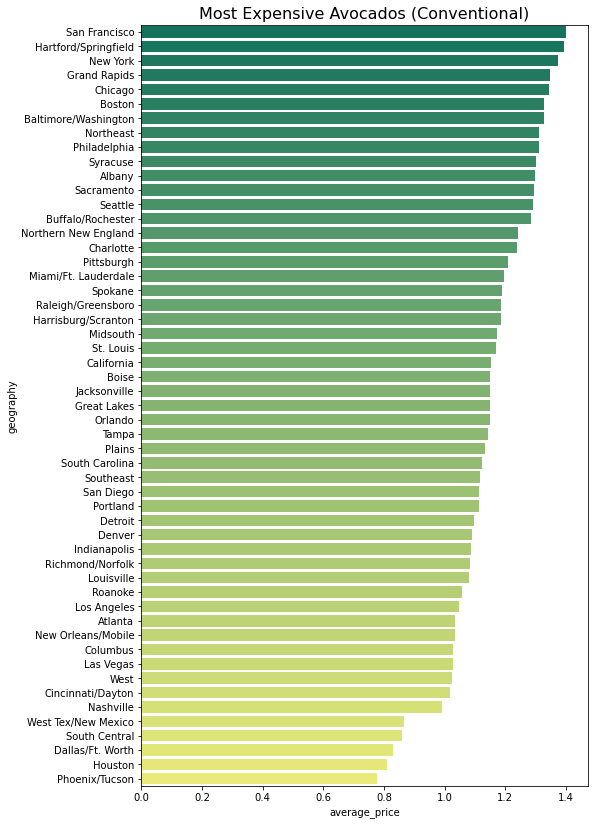

Wall time: 2.13 s


In [39]:
%%time
# price of conventional avocados by geography
conventional = df1.loc[df1["type"] == "conventional"]
avocado_conventional = conventional.groupby(["geography"])[["average_price"]].mean().sort_values(by = "average_price", ascending = False)

plt.figure(figsize = (8, 14))
sns.barplot(data = avocado_conventional, x = "average_price", y = avocado_conventional.index, color = "green", palette = "summer")
plt.title("Most Expensive Avocados (Conventional)", size = 16)
plt.show()

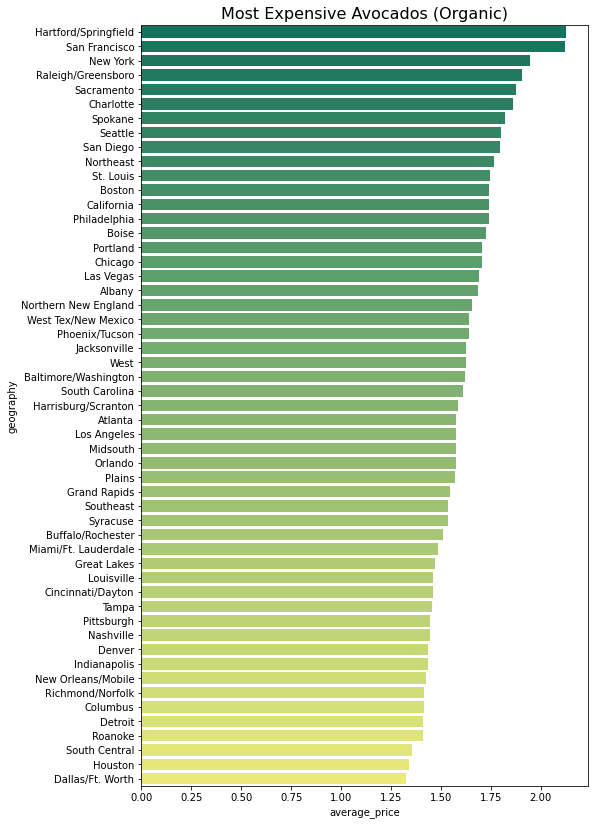

Wall time: 2.16 s


In [40]:
%%time
# price of organic avocados by geography
organic = df1.loc[df1["type"] == "organic"]
avocado_organic = organic.groupby(["geography"])[["average_price"]].mean().sort_values(by = "average_price", ascending = False)

plt.figure(figsize = (8, 14))
sns.barplot(data = avocado_organic, x = "average_price", y = avocado_organic.index, color = "lime", palette = "summer")
plt.title("Most Expensive Avocados (Organic)", size = 16)
plt.show()

#### Plot visualizations

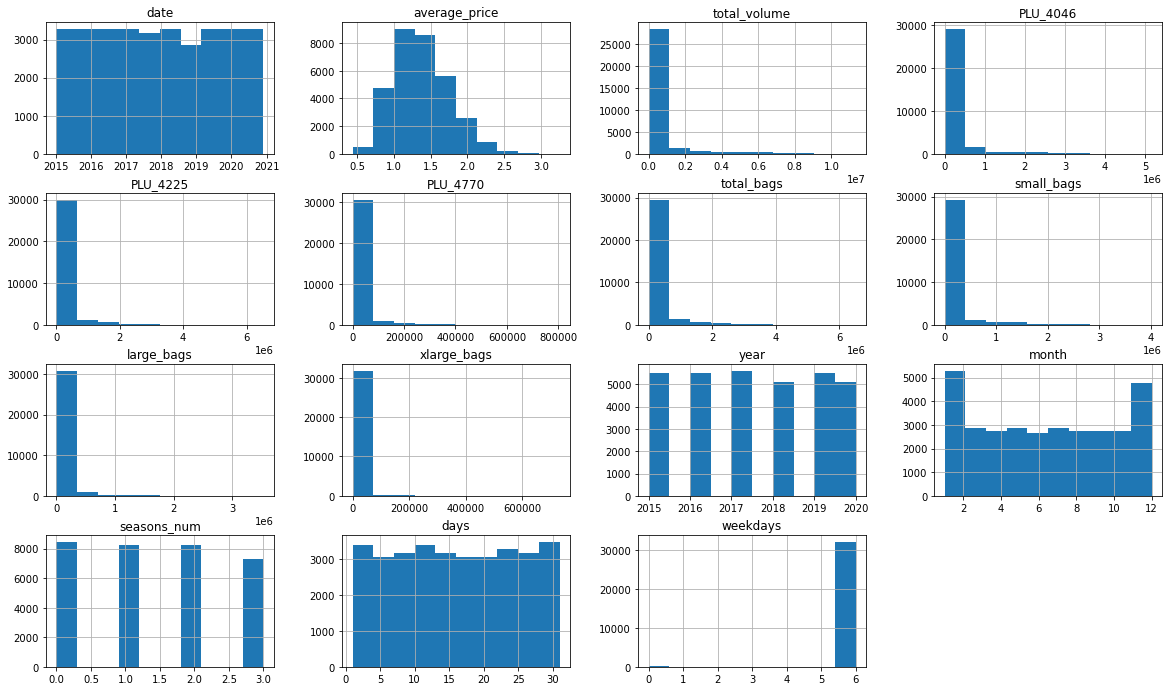

Wall time: 2.76 s


In [41]:
%%time
df1.hist(figsize=(20,15), layout=(5,4))
plt.show()

In [42]:
# Check skewness of the dataset.
# https://www.kaggle.com/ohguri/eda-and-prediction-with-parameter-tuning

cont_features = ['total_volume','PLU_4046','PLU_4225','PLU_4770','total_bags','small_bags','large_bags','xlarge_bags']

df1[cont_features].skew()

total_volume     3.570704
PLU_4046         4.322825
PLU_4225         4.714879
PLU_4770         6.454741
total_bags       4.715502
small_bags       4.088713
large_bags       7.264435
xlarge_bags     12.160528
dtype: float64

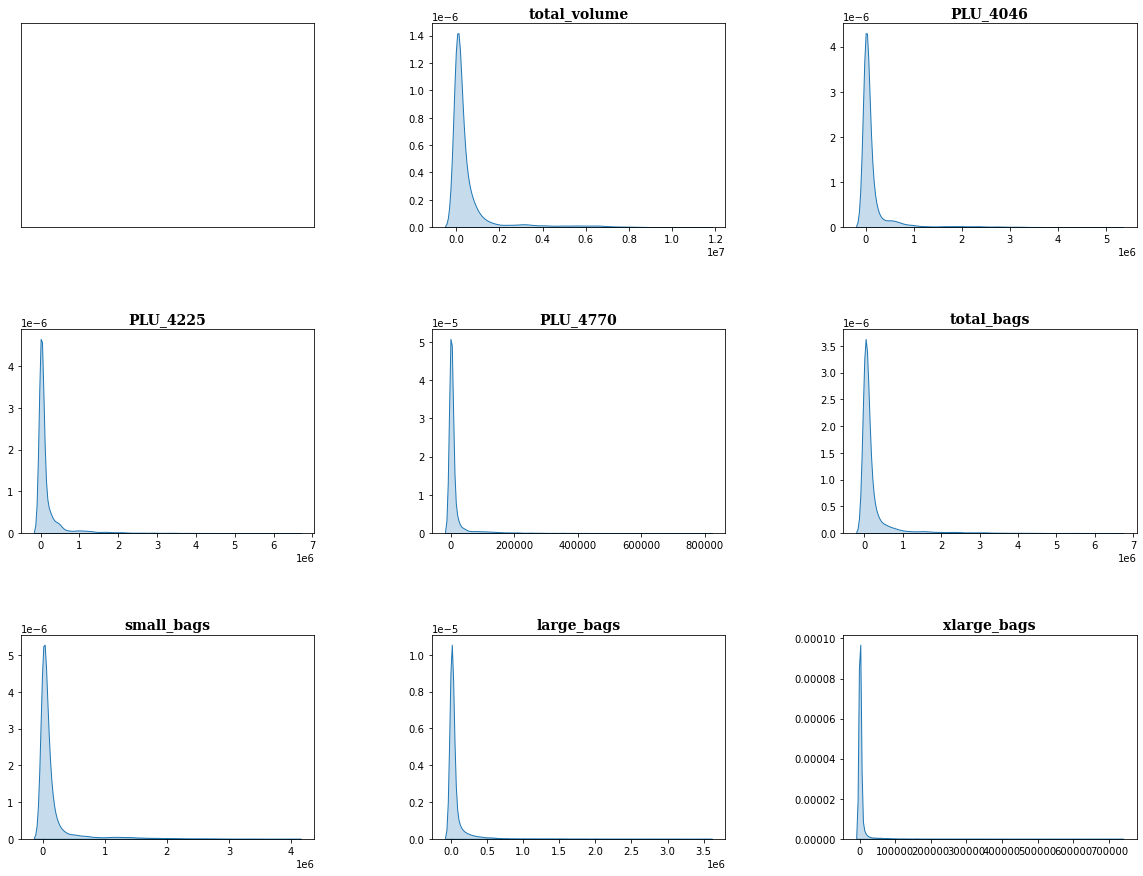

Wall time: 4.82 s


In [43]:
%%time
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.4, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]


# Graphs
for i, ax in enumerate(axes):
       
    
    if i == 0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(left=False, bottom=False)

    else:
        ax.set_title(cont_features[i-1], fontsize=14, fontfamily='serif', fontweight='bold')
    
        sns.kdeplot(x=cont_features[i-1], data=df1, ax=ax, palette="pastel", fill=True)
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.show()

In [44]:
# Use 'sqrt' to remove skewness.

np.sqrt(df1[cont_features]).skew()

total_volume    2.033065
PLU_4046        2.349876
PLU_4225        2.230137
PLU_4770        2.980532
total_bags      2.351934
small_bags      2.203681
large_bags      2.960196
xlarge_bags     4.330748
dtype: float64

In [45]:
# Try higher root. When we use 6th root, it's much better.

(df1[cont_features] ** (1/6)).skew()

total_volume    0.642328
PLU_4046        0.573784
PLU_4225        0.454381
PLU_4770        0.502203
total_bags      0.628534
small_bags      0.436909
large_bags      0.137955
xlarge_bags     1.083165
dtype: float64

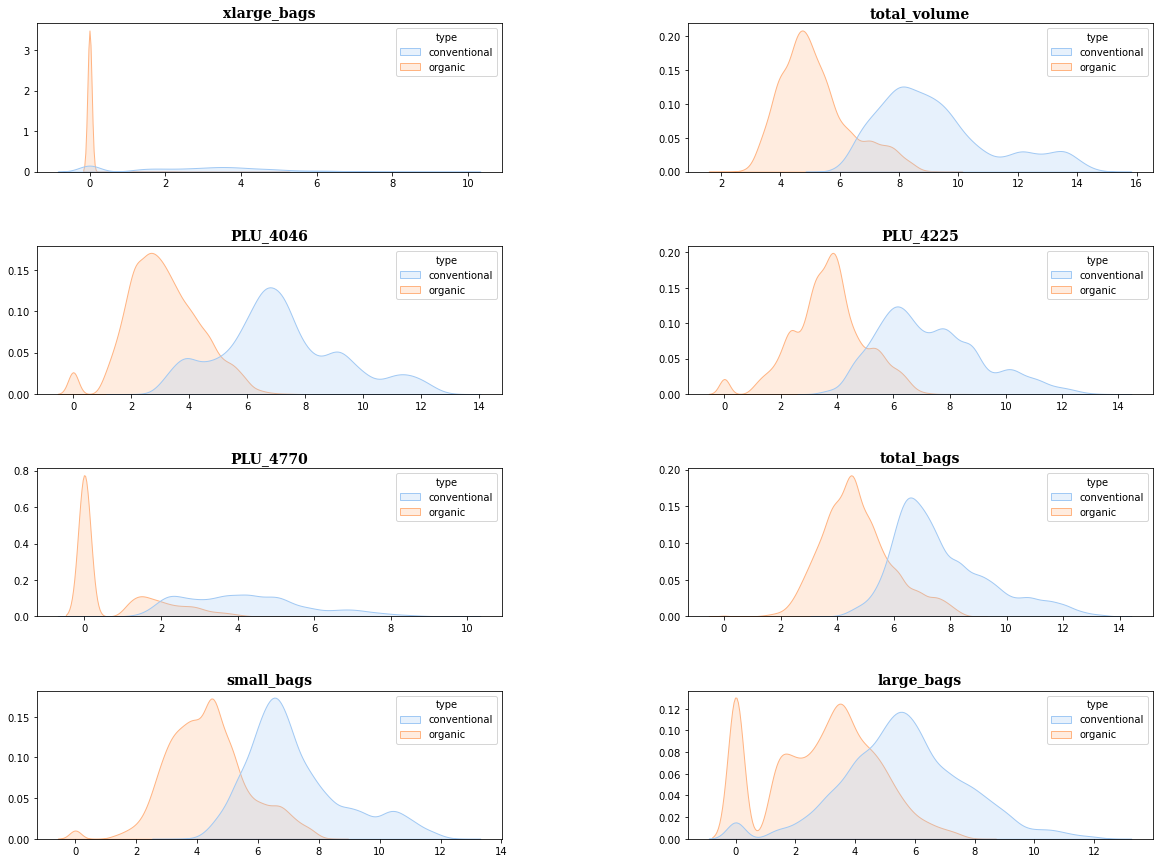

Wall time: 3.45 s


In [46]:
%%time
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.4, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1])
# ax8 = fig.add_subplot(gs[4, 0])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]


# Graphs
for i, ax in enumerate(axes):
       
    
#     if i == 0:
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.tick_params(left=False, bottom=False)

#     else:
    ax.set_title(cont_features[i-1], fontsize=14, fontfamily='serif', fontweight='bold')

    sns.kdeplot(x=df1[cont_features[i-1]]**(1/6), data=df1, ax=ax, palette="pastel", hue='type', fill=True)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

In [47]:
# distribution of avocados by Haas codes & Bag avocados

label1 = 'PLU4046','PLU4225','PLU4770'
label2 = 'Small Bags','Large Bags','XL Bags'
labels = label1 + label2

PLU4046 = int(df1['PLU_4046'].sum())
PLU4225 = int(df1['PLU_4225'].sum())
PLU4770 = int(df1['PLU_4770'].sum())

small = int(df1['small_bags'].sum())
large = int(df1['large_bags'].sum())
xl = int(df1['xlarge_bags'].sum())

plu_count = [PLU4046,PLU4225,PLU4770]
bags = [small,large,xl]
total_avocado = [PLU4046,PLU4225,PLU4770,small,large,xl]

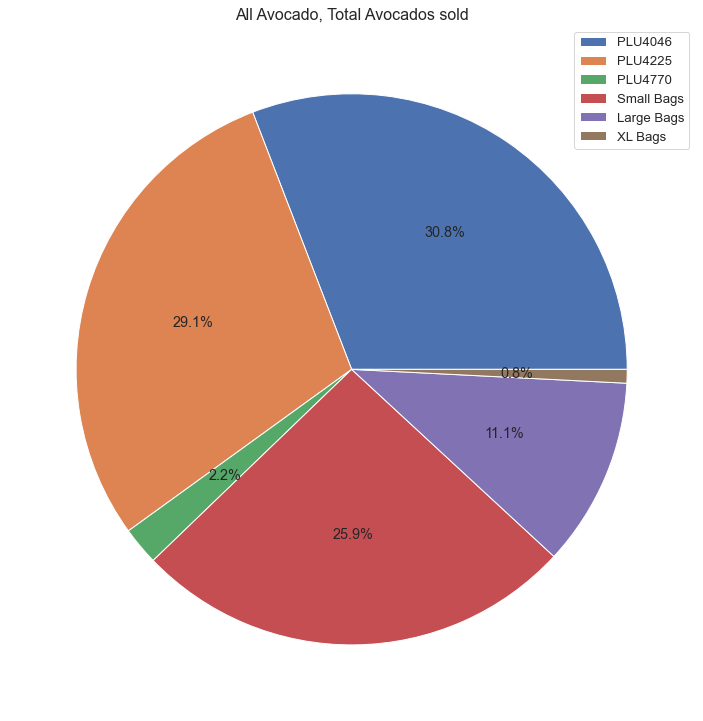

Wall time: 341 ms


In [165]:
%%time
#make a circle diagram; pie chart
# Creating plot 
plt.figure(figsize=(10,10))
plt.pie(total_avocado, autopct='%1.1f%%')
plt.legend(labels, loc = "upper right")
plt.tight_layout()
plt.title("All Avocado, Total Avocados sold", size = 16)
  
# show plot 
plt.show() 

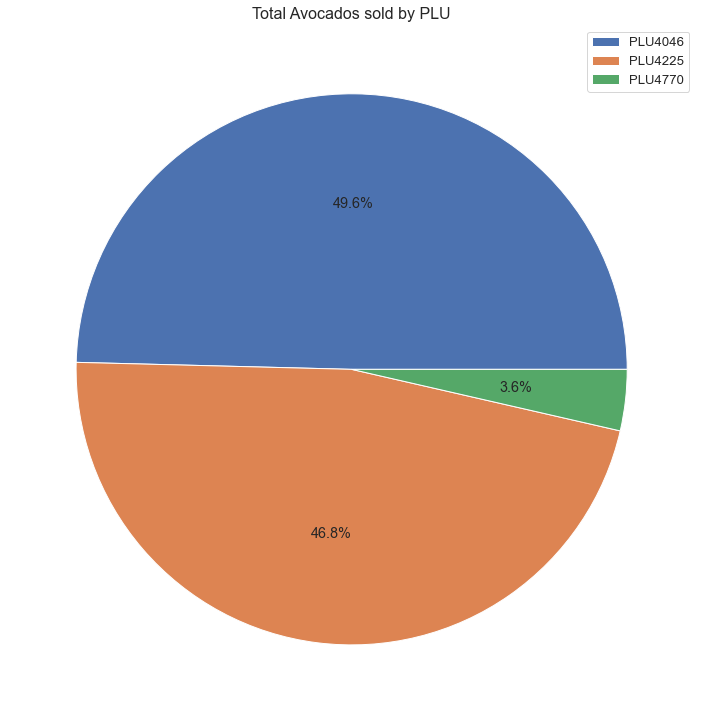

Wall time: 542 ms


In [166]:
%%time
#make a circle diagram; pie chart
# Creating plot 
plt.figure(figsize=(10,10))
plt.pie(plu_count, autopct='%1.1f%%')
plt.legend(label1, loc = "upper right")
plt.tight_layout()
plt.title("Total Avocados sold by PLU", size = 16)
  
# show plot 
plt.show() 

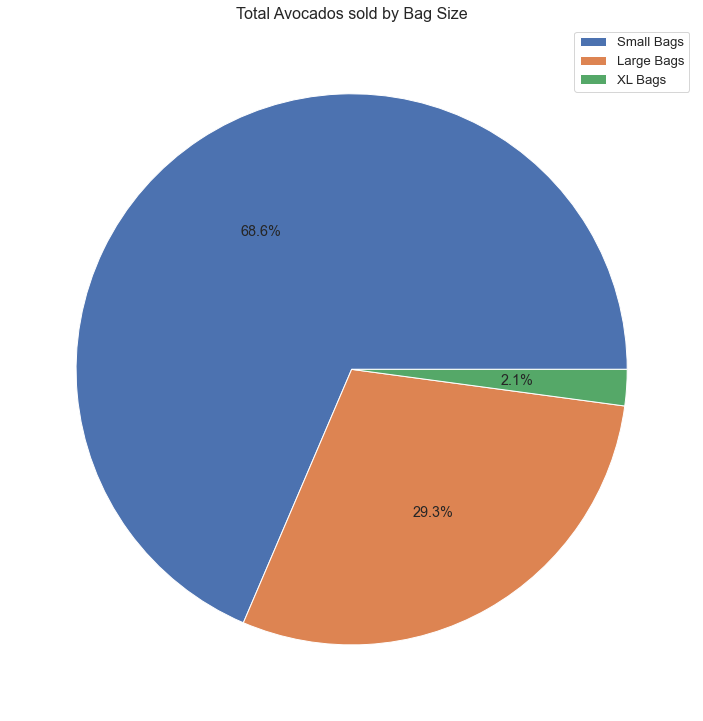

Wall time: 219 ms


In [167]:
%%time
#make a circle diagram; pie chart
# Creating plot 
plt.figure(figsize=(10,10))
plt.pie(bags, autopct='%1.1f%%')
plt.legend(label2, loc = "upper right")
plt.tight_layout()
plt.title("Total Avocados sold by Bag Size", size = 16)
  
# show plot 
plt.show() 

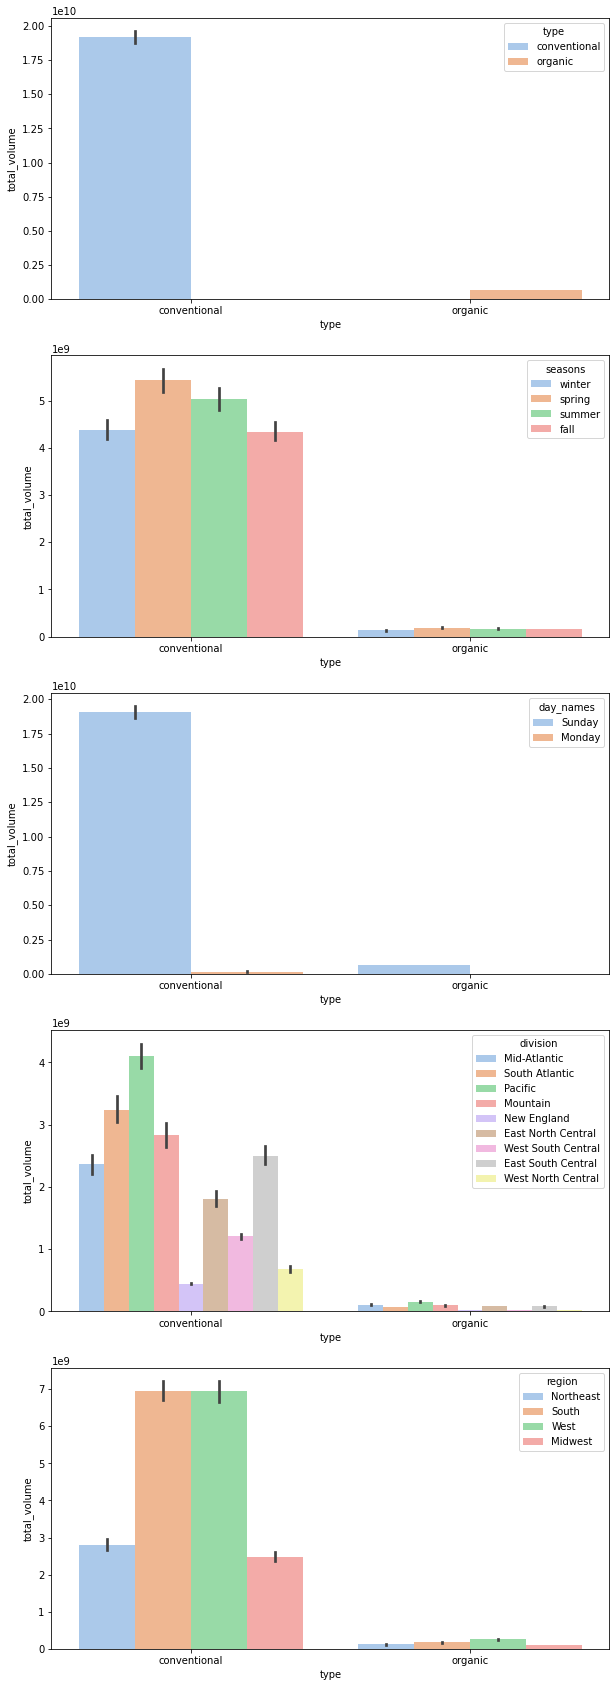

Wall time: 20.9 s


In [51]:
%%time

## countplot is useless in this dataset because the number of avocado sold are grouped per week.

catVars_volume = df1_cat[['type','seasons','day_names','division','region']][:-1]

fig ,ax = plt.subplots(5,1,figsize=(10,30))
for axi ,var in zip(ax.flat,catVars_volume):
    sns.barplot(x=df1_cat.type,y=df1_num.total_volume,hue=df1_cat[var],ax=axi, palette="pastel", estimator=sum)

plt.show()

Wall time: 2.15 s


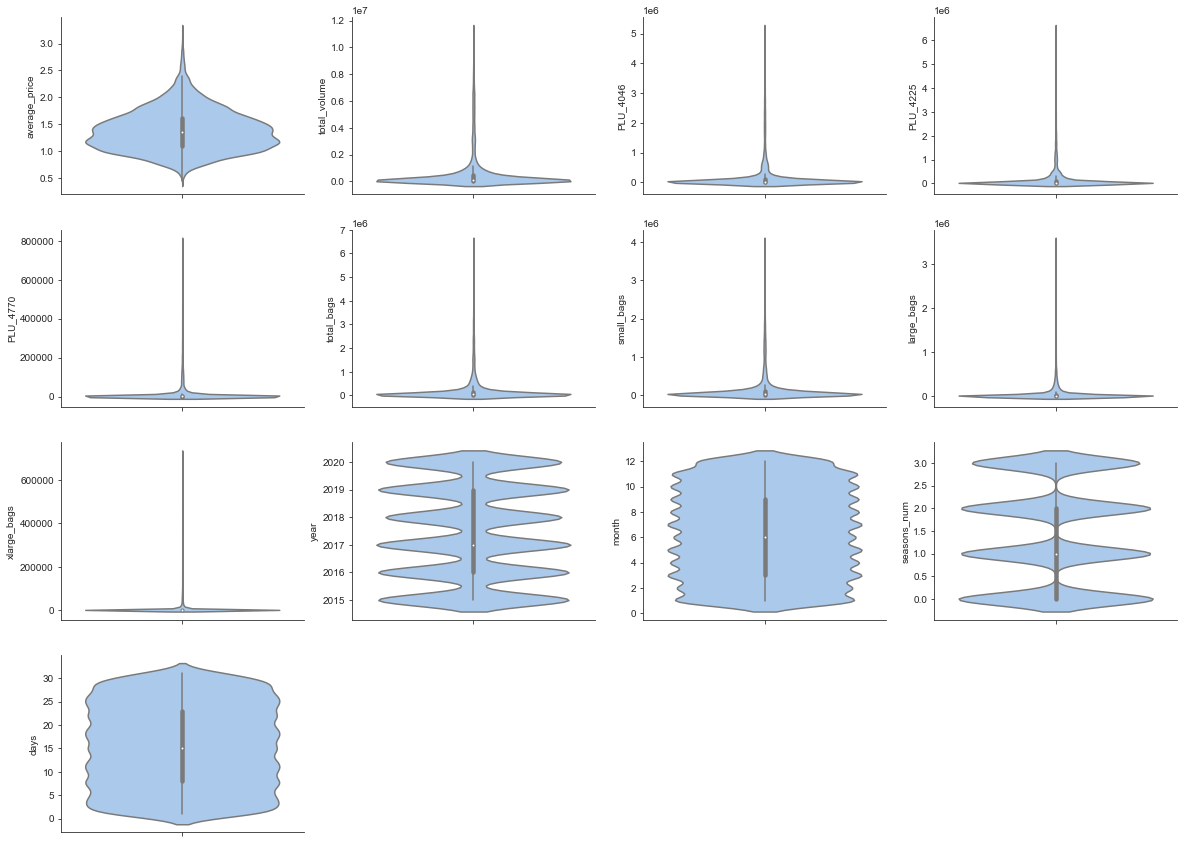

In [52]:
%%time
features = list(df1_num.columns)[:-1]

plt.figure(figsize=(20, 15))
sns.set_style('ticks')

for i, feature in enumerate(features):
    plt.subplot(4, 4, i+1)
    sns.violinplot(data=df1_num, y=feature, palette="pastel", estimator=sum)  
    
sns.despine()

Wall time: 178 ms


Text(0.5, 1.0, 'Avocado Average price')

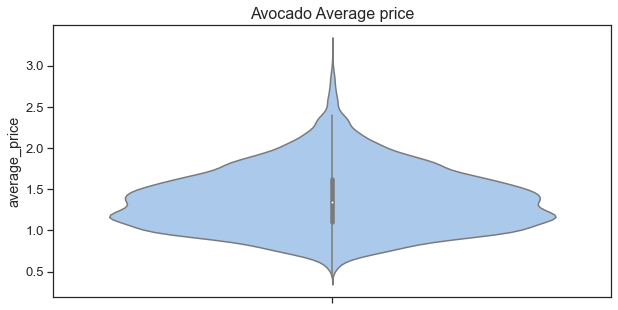

In [168]:
%%time
plt.figure(figsize=(10, 5))
_ = sns.violinplot(y='average_price', data=df1, palette="pastel")
plt.title("Avocado Average price", size = 16)

Wall time: 86.8 ms


<Figure size 720x360 with 0 Axes>

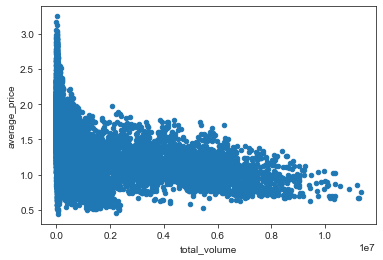

In [55]:
%%time
plt.figure(figsize=(10, 5))
_ = df1.plot.scatter('total_volume', 'average_price')

Wall time: 881 ms


<Figure size 720x360 with 0 Axes>

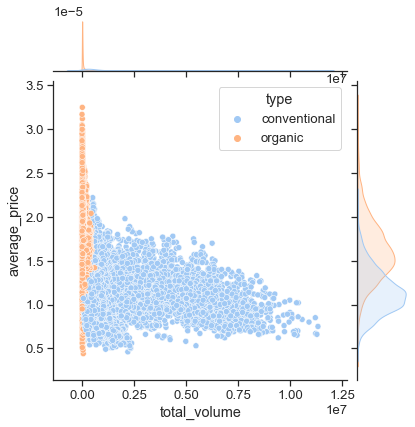

In [170]:
%%time
plt.figure(figsize=(10, 5))
_ = sns.jointplot(x="total_volume", y="average_price", data=df1, hue='type', estimator=sum, palette="pastel")
# plt.title("Avocado Average price vs Volume by Type", size = 16)

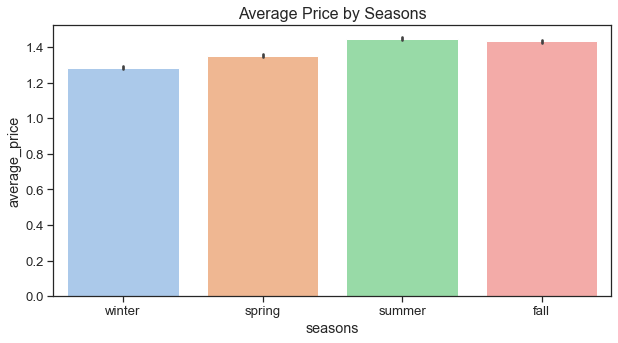

Wall time: 700 ms


In [171]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='seasons', y='average_price', data=df1, palette="pastel")
plt.title('Average Price by Seasons', size = 16)
plt.show()

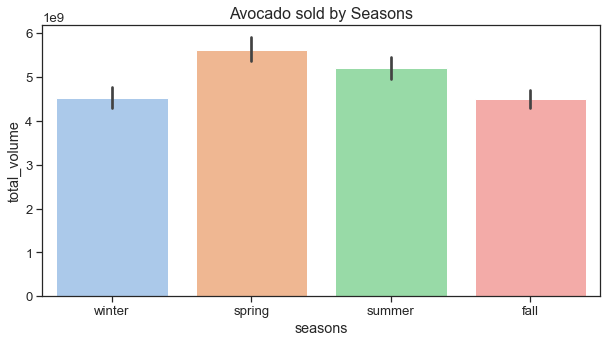

Wall time: 4.08 s


In [172]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='seasons', y='total_volume', data=df1, estimator=sum, palette="pastel")
plt.title('Avocado sold by Seasons', size = 16)
plt.show()

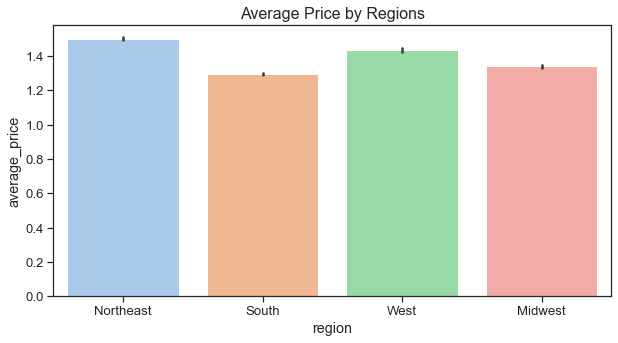

Wall time: 603 ms


In [173]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='region', y='average_price', data=df1, palette="pastel")
plt.title('Average Price by Regions', size = 16)
plt.show()

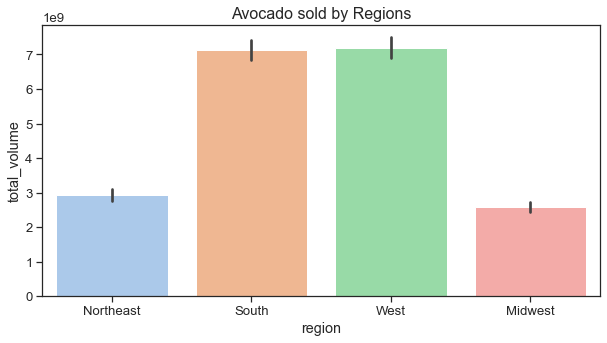

Wall time: 3.9 s


In [174]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='region', y='total_volume', data=df1, estimator=sum, palette="pastel")
plt.title('Avocado sold by Regions', size = 16)
plt.show()

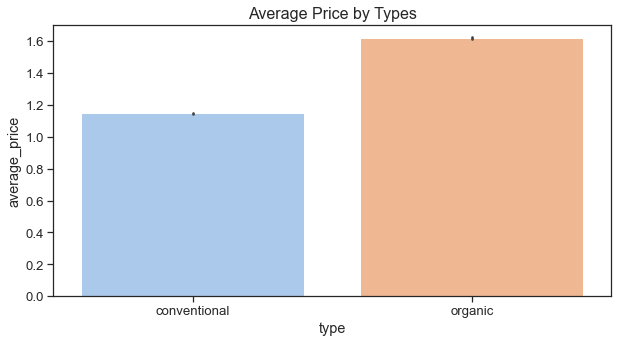

Wall time: 533 ms


In [175]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='type', y='average_price', data=df1, palette="pastel")
plt.title('Average Price by Types', size = 16)
plt.show()

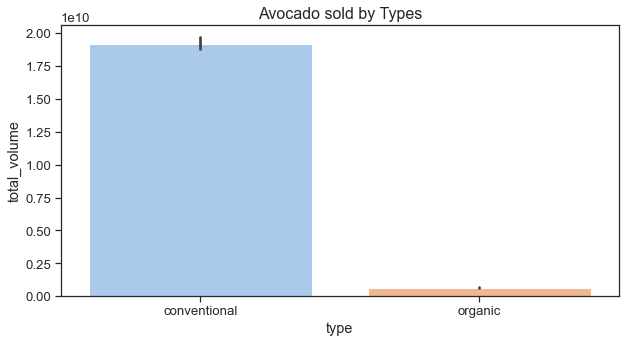

Wall time: 4.11 s


In [176]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='type', y='total_volume', data=df1, estimator=sum, palette="pastel")
plt.title('Avocado sold by Types', size = 16)
plt.show()

Wall time: 3.82 s


Text(0.5, 1.0, 'Avocado sold by Year')

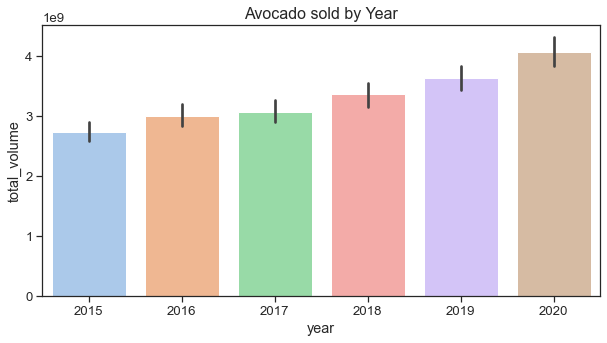

In [184]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='year', y='total_volume', data=df1, estimator=sum, palette="pastel")
plt.title('Avocado sold by Year', size = 16)

Wall time: 3.2 s


Text(0.5, 1.0, 'Average Price by Year')

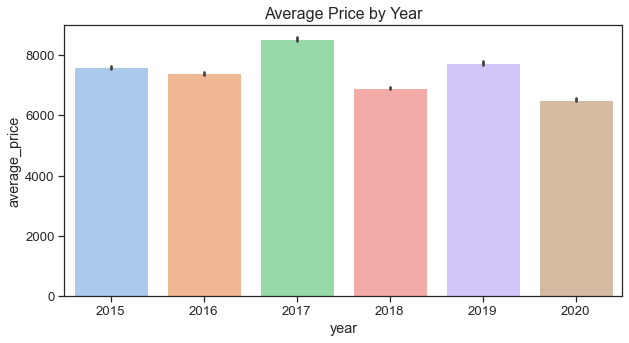

In [185]:
%%time
plt.figure(figsize=(10, 5))
fig = sns.barplot(x='year', y='average_price', data=df1, estimator=sum, palette="pastel")
plt.title('Average Price by Year', size = 16)

Wall time: 315 ms


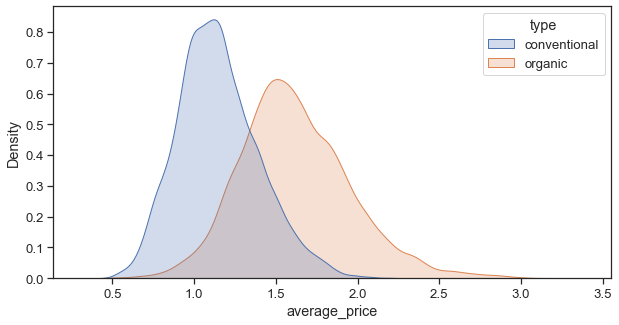

In [69]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')
_ = sns.kdeplot('average_price', data=df1, shade=True, hue='type')

Wall time: 261 ms


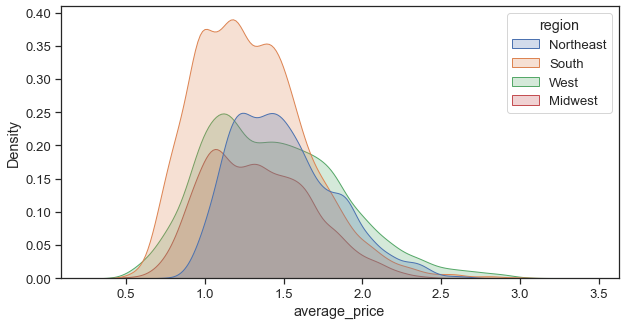

In [70]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')
_ = sns.kdeplot('average_price', data=df1, shade=True, hue='region')

Wall time: 258 ms


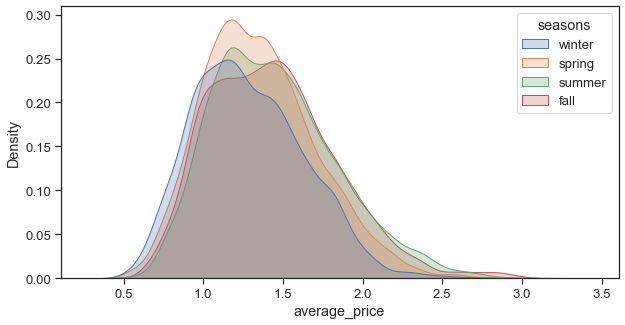

In [71]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')
_ = sns.kdeplot('average_price', data=df1, shade=True, hue='seasons')

Wall time: 3.15 s


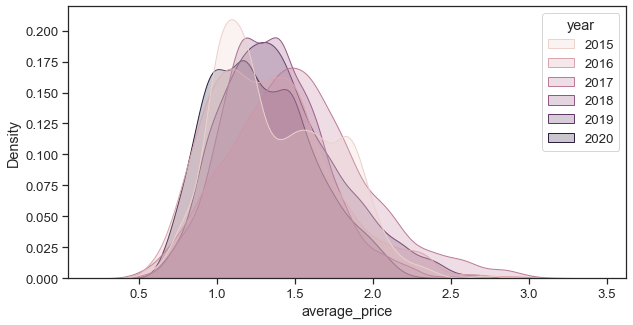

In [72]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')
_ = sns.kdeplot('average_price', data=df1, shade=True, hue='year')

Wall time: 883 ms


Text(0.5, 1.0, 'Average Price by Type across Years')

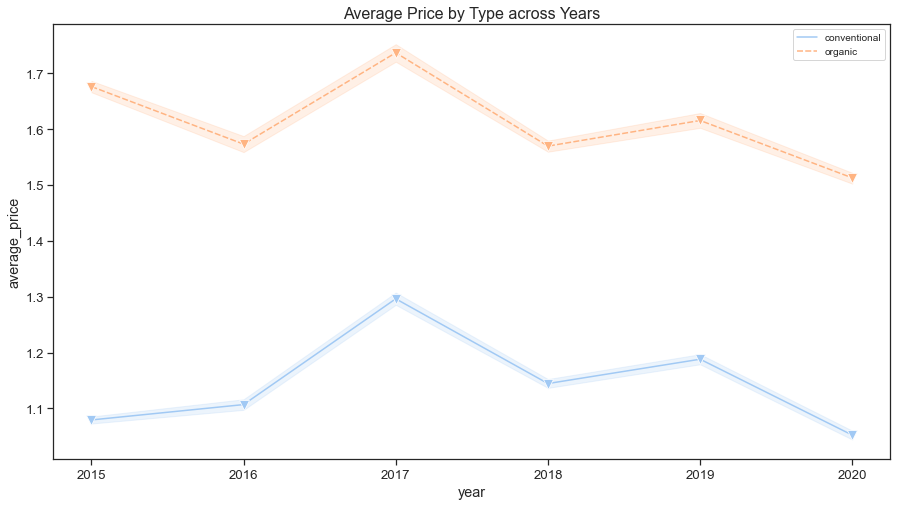

In [147]:
%%time
plt.figure(figsize=(15, 8))
sns.lineplot(x="year", y="average_price", hue="type", style="type", marker= 'v', markersize=10, 
             palette="pastel", data=df1)
plt.legend(ncol=1, loc="upper right", fontsize=10, frameon=True)
plt.title("Average Price by Type across Years", size = 16)

Wall time: 2.11 s


Text(0.5, 1.0, 'Monthly Average Price of conventional Avocado across Years')

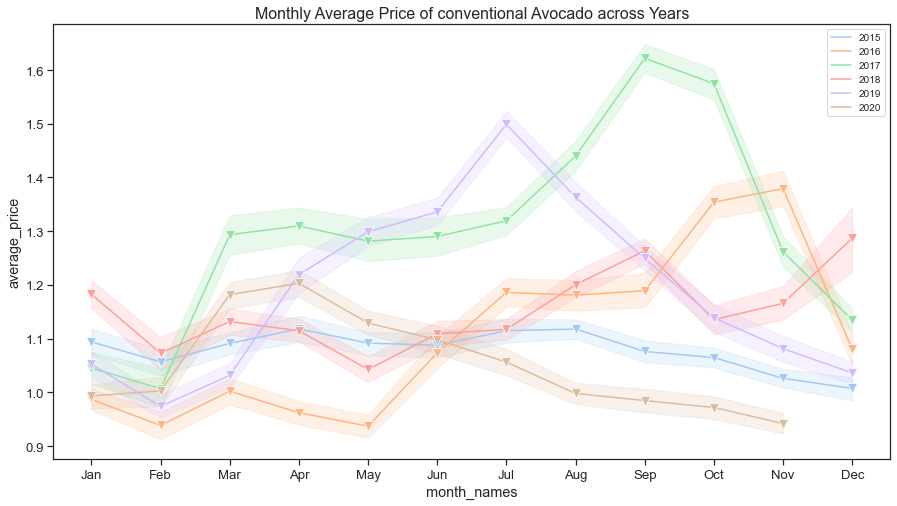

In [161]:
%%time
plt.figure(figsize=(15, 8))
sns.lineplot(x="month_names", y="average_price", hue="year", marker= 'v', markersize=10, 
             palette="pastel", data=df1.loc[df["type"] == "conventional"])
plt.legend(ncol=1, loc="upper right", fontsize=10, frameon=True)
plt.title("Monthly Average Price of conventional Avocado across Years", size = 16)

Wall time: 2.07 s


Text(0.5, 1.0, 'Monthly Average Price of organic Avocado across Years')

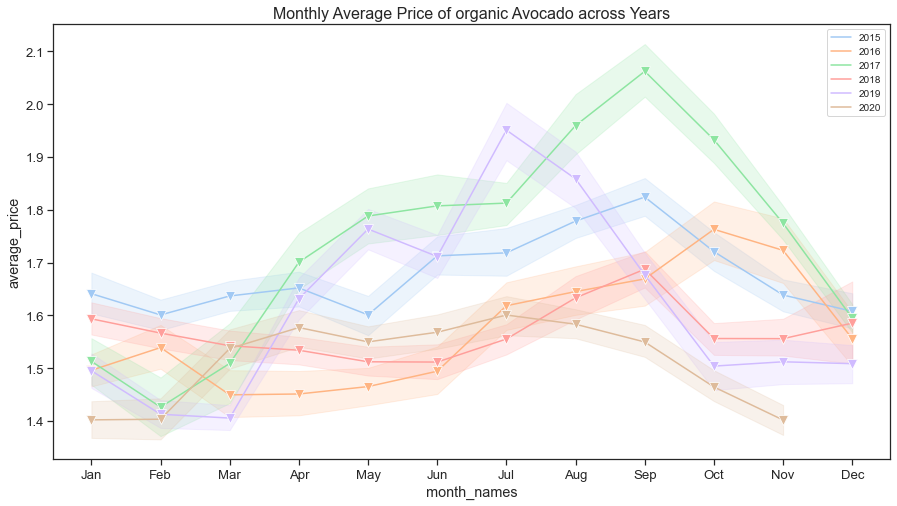

In [162]:
%%time
plt.figure(figsize=(15, 8))
sns.lineplot(x="month_names", y="average_price", hue="year", marker= 'v', markersize=10, 
             palette="pastel", data=df1.loc[df["type"] == "organic"])
plt.legend(ncol=1, loc="upper right", fontsize=10, frameon=True)
plt.title("Monthly Average Price of organic Avocado across Years", size = 16)

Wall time: 1.37 s


Text(0.5, 1.0, 'Bag Avocado sold by Seasons')

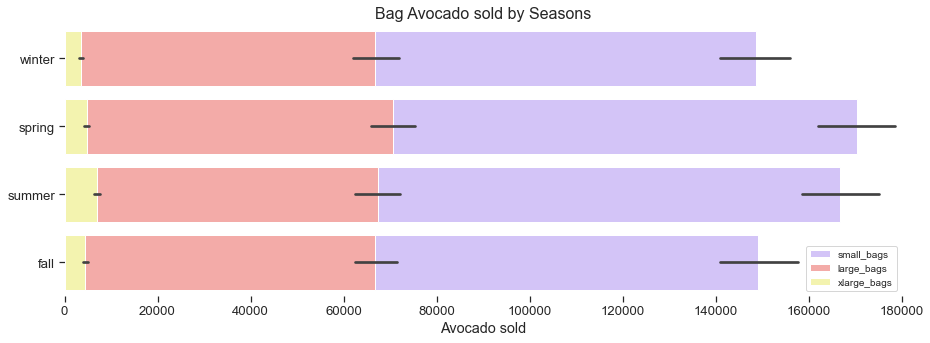

In [163]:
%%time
plt.figure(figsize=(15, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

# Plot Non-Hass Avocado sold
sns.set_color_codes("pastel")
_ = sns.barplot(x='small_bags', y='seasons', data=df1, label="small_bags", color='m')

sns.set_color_codes("pastel")
_ = sns.barplot(x='large_bags', y='seasons', data=df1, label="large_bags", color='r')

sns.set_color_codes("pastel")
_ = sns.barplot(x='xlarge_bags', y='seasons', data=df1, label="xlarge_bags", color='y')

# Add a legend and informative axis label
plt.legend(ncol=1, loc="lower right", fontsize=10, frameon=True)
_.set(xlim=(0, 180000), ylabel="",
       xlabel="Avocado sold")
sns.despine(left=True, bottom=True)
plt.title("Bag Avocado sold by Seasons", size = 16)

Wall time: 1.25 s


Text(0.5, 1.0, 'PLU Avocado sold by Seasons')

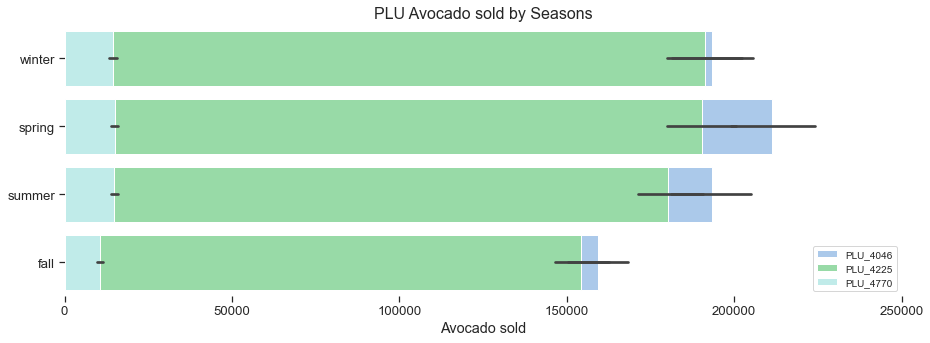

In [164]:
%%time
plt.figure(figsize=(15, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

# Plot Hass Avocado sold
sns.set_color_codes("pastel")
_ = sns.barplot(x='PLU_4046', y='seasons', data=df1, label="PLU_4046", color='b')

sns.set_color_codes("pastel")
_ = sns.barplot(x='PLU_4225', y='seasons', data=df1, label="PLU_4225", color='g')

sns.set_color_codes("pastel")
_ = sns.barplot(x='PLU_4770', y='seasons', data=df1, label="PLU_4770", color='c')

# Add a legend and informative axis label
plt.legend(ncol=1, loc="lower right", fontsize=10, frameon=True)
_.set(xlim=(0, 250000), ylabel="",
       xlabel="Avocado sold")
sns.despine(left=True, bottom=True)
plt.title("PLU Avocado sold by Seasons", size = 16)

### Create df2 from df1 to prepare for training

In [78]:
df2 = df1.copy()

#### Remove unnecessary features for training

In [79]:
# Drop unwanted columns in df2.
df2 = df2.drop(['date','seasons','day_names','geography','division','total_volume','total_bags'], axis=1)

In [80]:
df2.sample(5)

average_price    PLU_4046    PLU_4225  PLU_4770  small_bags  \
15329           1.53  1582315.47  1095433.56  47072.46   863081.25   
23598           1.50    36876.40    24329.54    359.34    55182.22   
3497            1.69     1275.73       49.21      9.16     2269.63   
30252           1.56      157.00     4944.00     42.00     9821.00   
19569           0.98   202983.76   379244.31  13531.29   190766.59   

       large_bags  xlarge_bags          type  year  month  seasons_num  days  \
15329   591149.15      2174.92  conventional  2017      9            2    17   
23598     2447.16         0.00       organic  2019      3            0    31   
3497        17.80         0.00       organic  2015      8            1    16   
30252     8109.00         0.00       organic  2020      6            1     7   
19569   206960.35        18.11  conventional  2018      6            1    17   

       weekdays     region  
15329         6       West  
23598         6  Northeast  
3497          6      South  
30252         6      South  
19569         6       West

## Data transformation

#### Convert categorical data into dummy or indicator variables.

In [81]:
# Encode labels for df2['type'] -> # Organic = 1, Conventional = 0
le = LabelEncoder()
df2['type'] = le.fit_transform(df2['type'])

# One hot encode df2['region']
df2 = pd.get_dummies(df2)

df2.head()

average_price   PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  \
0           1.22    2819.50   28287.42     49.90     9186.93      529.53   
1           1.79      57.42     153.88      0.00     1162.65        0.00   
2           1.00  364302.39   23821.16     82.15    16707.15    30108.64   
3           1.76    1500.15     938.35      0.00     1071.35      336.84   
4           1.08   53987.31  552906.04  39995.03   137146.07     3990.61   

   xlarge_bags  type  year  month  seasons_num  days  weekdays  \
0          0.0     0  2015      1            3     4         6   
1          0.0     1  2015      1            3     4         6   
2          0.0     0  2015      1            3     4         6   
3          0.0     1  2015      1            3     4         6   
4          0.0     0  2015      1            3     4         6   

   region_Midwest  region_Northeast  region_South  region_West  
0               0                 1             0            0  
1               0                 1             0            0  
2               0                 0             1            0  
3               0                 0             1            0  
4               0                 0             0            1

In [82]:
# Rearrange the column of dataframe by column position in pandas python
df2=df2[df2.columns[[1,2,3,4,5,6,11,12,9,8,10,13,14,15,16,7,0]]]

df2

PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
0         2819.50   28287.42     49.90     9186.93      529.53         0.00   
1           57.42     153.88      0.00     1162.65        0.00         0.00   
2       364302.39   23821.16     82.15    16707.15    30108.64         0.00   
3         1500.15     938.35      0.00     1071.35      336.84         0.00   
4        53987.31  552906.04  39995.03   137146.07     3990.61         0.00   
...           ...        ...       ...         ...         ...          ...   
33038      101.71       0.00      0.00    11782.17        0.00         0.00   
33041  1352877.53  589061.83  19741.90  2197611.02  1531530.14     61524.13   
33042    13273.75   19341.09    636.51   122606.21   134103.71         0.00   
33043   234688.01   80205.15  10543.63   285764.11   210808.02       809.83   
33044     1236.96     617.80   1564.98    17824.52     2862.32         0.00   

       days  weekdays  month  year  seasons_num  region_Midwest  \
0         4         6      1  2015            3               0   
1         4         6      1  2015            3               0   
2         4         6      1  2015            3               0   
3         4         6      1  2015            3               0   
4         4         6      1  2015            3               0   
...     ...       ...    ...   ...          ...             ...   
33038    29         6     11  2020            2               0   
33041    29         6     11  2020            2               0   
33042    29         6     11  2020            2               0   
33043    29         6     11  2020            2               0   
33044    29         6     11  2020            2               0   

       region_Northeast  region_South  region_West  type  average_price  
0                     1             0            0     0           1.22  
1                     1             0            0     1           1.79  
2                     0             1            0     0           1.00  
3                     0             1            0     1           1.76  
4                     0             0            1     0           1.08  
...                 ...           ...          ...   ...            ...  
33038                 0             1            0     1           0.95  
33041                 0             0            1     0           0.91  
33042                 0             0            1     1           1.48  
33043                 0             1            0     0           0.67  
33044                 0             1            0     1           1.35  

[32326 rows x 17 columns]

In [83]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32326 entries, 0 to 33044
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PLU_4046          32326 non-null  float64
 1   PLU_4225          32326 non-null  float64
 2   PLU_4770          32326 non-null  float64
 3   small_bags        32326 non-null  float64
 4   large_bags        32326 non-null  float64
 5   xlarge_bags       32326 non-null  float64
 6   days              32326 non-null  int64  
 7   weekdays          32326 non-null  int64  
 8   month             32326 non-null  int64  
 9   year              32326 non-null  int64  
 10  seasons_num       32326 non-null  int32  
 11  region_Midwest    32326 non-null  uint8  
 12  region_Northeast  32326 non-null  uint8  
 13  region_South      32326 non-null  uint8  
 14  region_West       32326 non-null  uint8  
 15  type              32326 non-null  int32  
 16  average_price     32326 non-null  float6

In [84]:
# look at correlations in the numerical independent variables, as well as the dependent variable
df2.corr()

PLU_4046  PLU_4225  PLU_4770  small_bags  large_bags  \
PLU_4046          1.000000  0.545994  0.511523    0.796670    0.622255   
PLU_4225          0.545994  1.000000  0.528091    0.686677    0.417216   
PLU_4770          0.511523  0.528091  1.000000    0.568529    0.361789   
small_bags        0.796670  0.686677  0.568529    1.000000    0.710301   
large_bags        0.622255  0.417216  0.361789    0.710301    1.000000   
xlarge_bags       0.407607  0.280236  0.483549    0.583999    0.481442   
days             -0.013490 -0.016373 -0.009661   -0.008436   -0.007605   
weekdays         -0.002759 -0.000838  0.000079   -0.010354   -0.017657   
month            -0.038405 -0.038635 -0.040582   -0.019300   -0.009722   
year              0.014697 -0.032297 -0.034704    0.153094    0.191436   
seasons_num      -0.020572 -0.007273 -0.015946   -0.024830   -0.006069   
region_Midwest   -0.067026 -0.035053  0.152018   -0.024439   -0.058620   
region_Northeast -0.163680  0.105579 -0.117385   -0.068415   -0.096091   
region_South      0.112825 -0.117147 -0.068028   -0.005403    0.011825   
region_West       0.084935  0.060147  0.052504    0.089623    0.125454   
type             -0.360531 -0.376012 -0.286171   -0.374032   -0.271760   
average_price    -0.341407 -0.229709 -0.220592   -0.299219   -0.239134   

                  xlarge_bags      days  weekdays     month      year  \
PLU_4046             0.407607 -0.013490 -0.002759 -0.038405  0.014697   
PLU_4225             0.280236 -0.016373 -0.000838 -0.038635 -0.032297   
PLU_4770             0.483549 -0.009661  0.000079 -0.040582 -0.034704   
small_bags           0.583999 -0.008436 -0.010354 -0.019300  0.153094   
large_bags           0.481442 -0.007605 -0.017657 -0.009722  0.191436   
xlarge_bags          1.000000 -0.003132 -0.005436  0.007558  0.154184   
days                -0.003132  1.000000  0.083732 -0.006412 -0.003883   
weekdays            -0.005436  0.083732  1.000000  0.129711 -0.097420   
month                0.007558 -0.006412  0.129711  1.000000 -0.031089   
year                 0.154184 -0.003883 -0.097420 -0.031089  1.000000   
seasons_num         -0.025614 -0.034093 -0.114124  0.171041 -0.033748   
region_Midwest       0.036134 -0.000010  0.000005  0.000018 -0.000007   
region_Northeast    -0.075583 -0.000011  0.000005  0.000021 -0.000008   
region_South        -0.061943  0.000030 -0.000013 -0.000054  0.000020   
region_West          0.106124 -0.000013  0.000006  0.000024 -0.000009   
type                -0.195102  0.000022 -0.000010 -0.000041  0.000015   
average_price       -0.126585  0.028346  0.030700  0.110740 -0.054440   

                  seasons_num  region_Midwest  region_Northeast  region_South  \
PLU_4046            -0.020572       -0.067026         -0.163680      0.112825   
PLU_4225            -0.007273       -0.035053          0.105579     -0.117147   
PLU_4770            -0.015946        0.152018         -0.117385     -0.068028   
small_bags          -0.024830       -0.024439         -0.068415     -0.005403   
large_bags          -0.006069       -0.058620         -0.096091      0.011825   
xlarge_bags         -0.025614        0.036134         -0.075583     -0.061943   
days                -0.034093       -0.000010         -0.000011      0.000030   
weekdays            -0.114124        0.000005          0.000005     -0.000013   
month                0.171041        0.000018          0.000021     -0.000054   
year                -0.033748       -0.000007         -0.000008      0.000020   
seasons_num          1.000000        0.000003          0.000003     -0.000008   
region_Midwest       0.000003        1.000000         -0.231490     -0.338057   
region_Northeast     0.000003       -0.231490          1.000000     -0.382532   
region_South        -0.000008       -0.338057         -0.382532      1.000000   
region_West          0.000004       -0.271016         -0.306672     -0.447848   
type                -0.000006        0.000056          0.000063     -0.000

Wall time: 464 ms


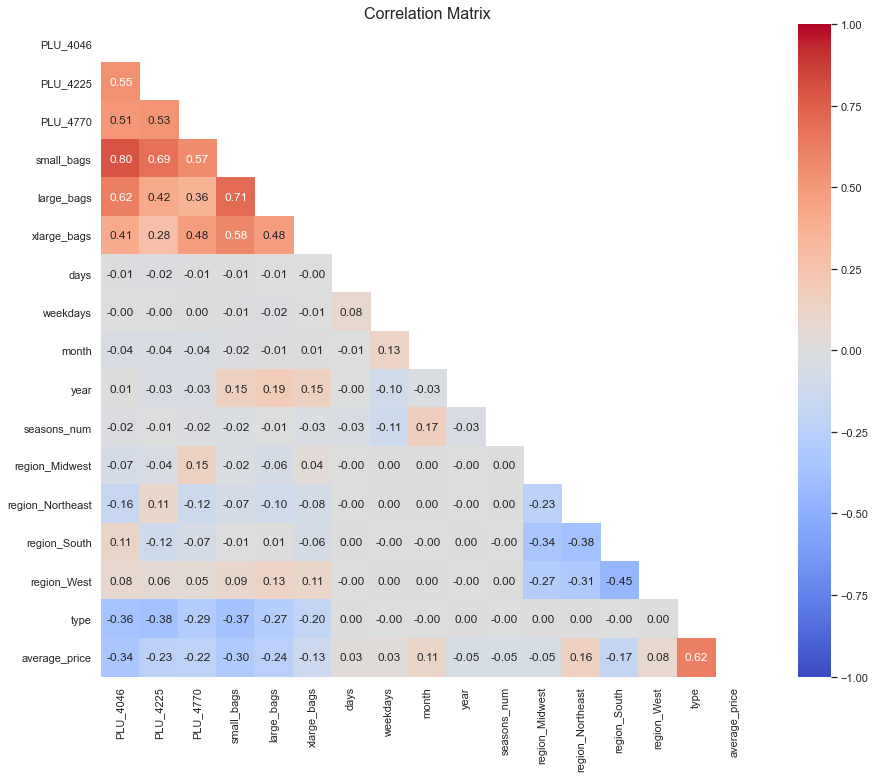

In [85]:
%%time
# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(df2.corr())

# Set up the matplotlib figure to control size & title of heatmap
fig, ax = plt.subplots(figsize=(16,12))
ax.set_title('Correlation Matrix', fontsize=16)

# Plot the heatmap
_ = sns.heatmap(df2.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f') 

Wall time: 2min 52s


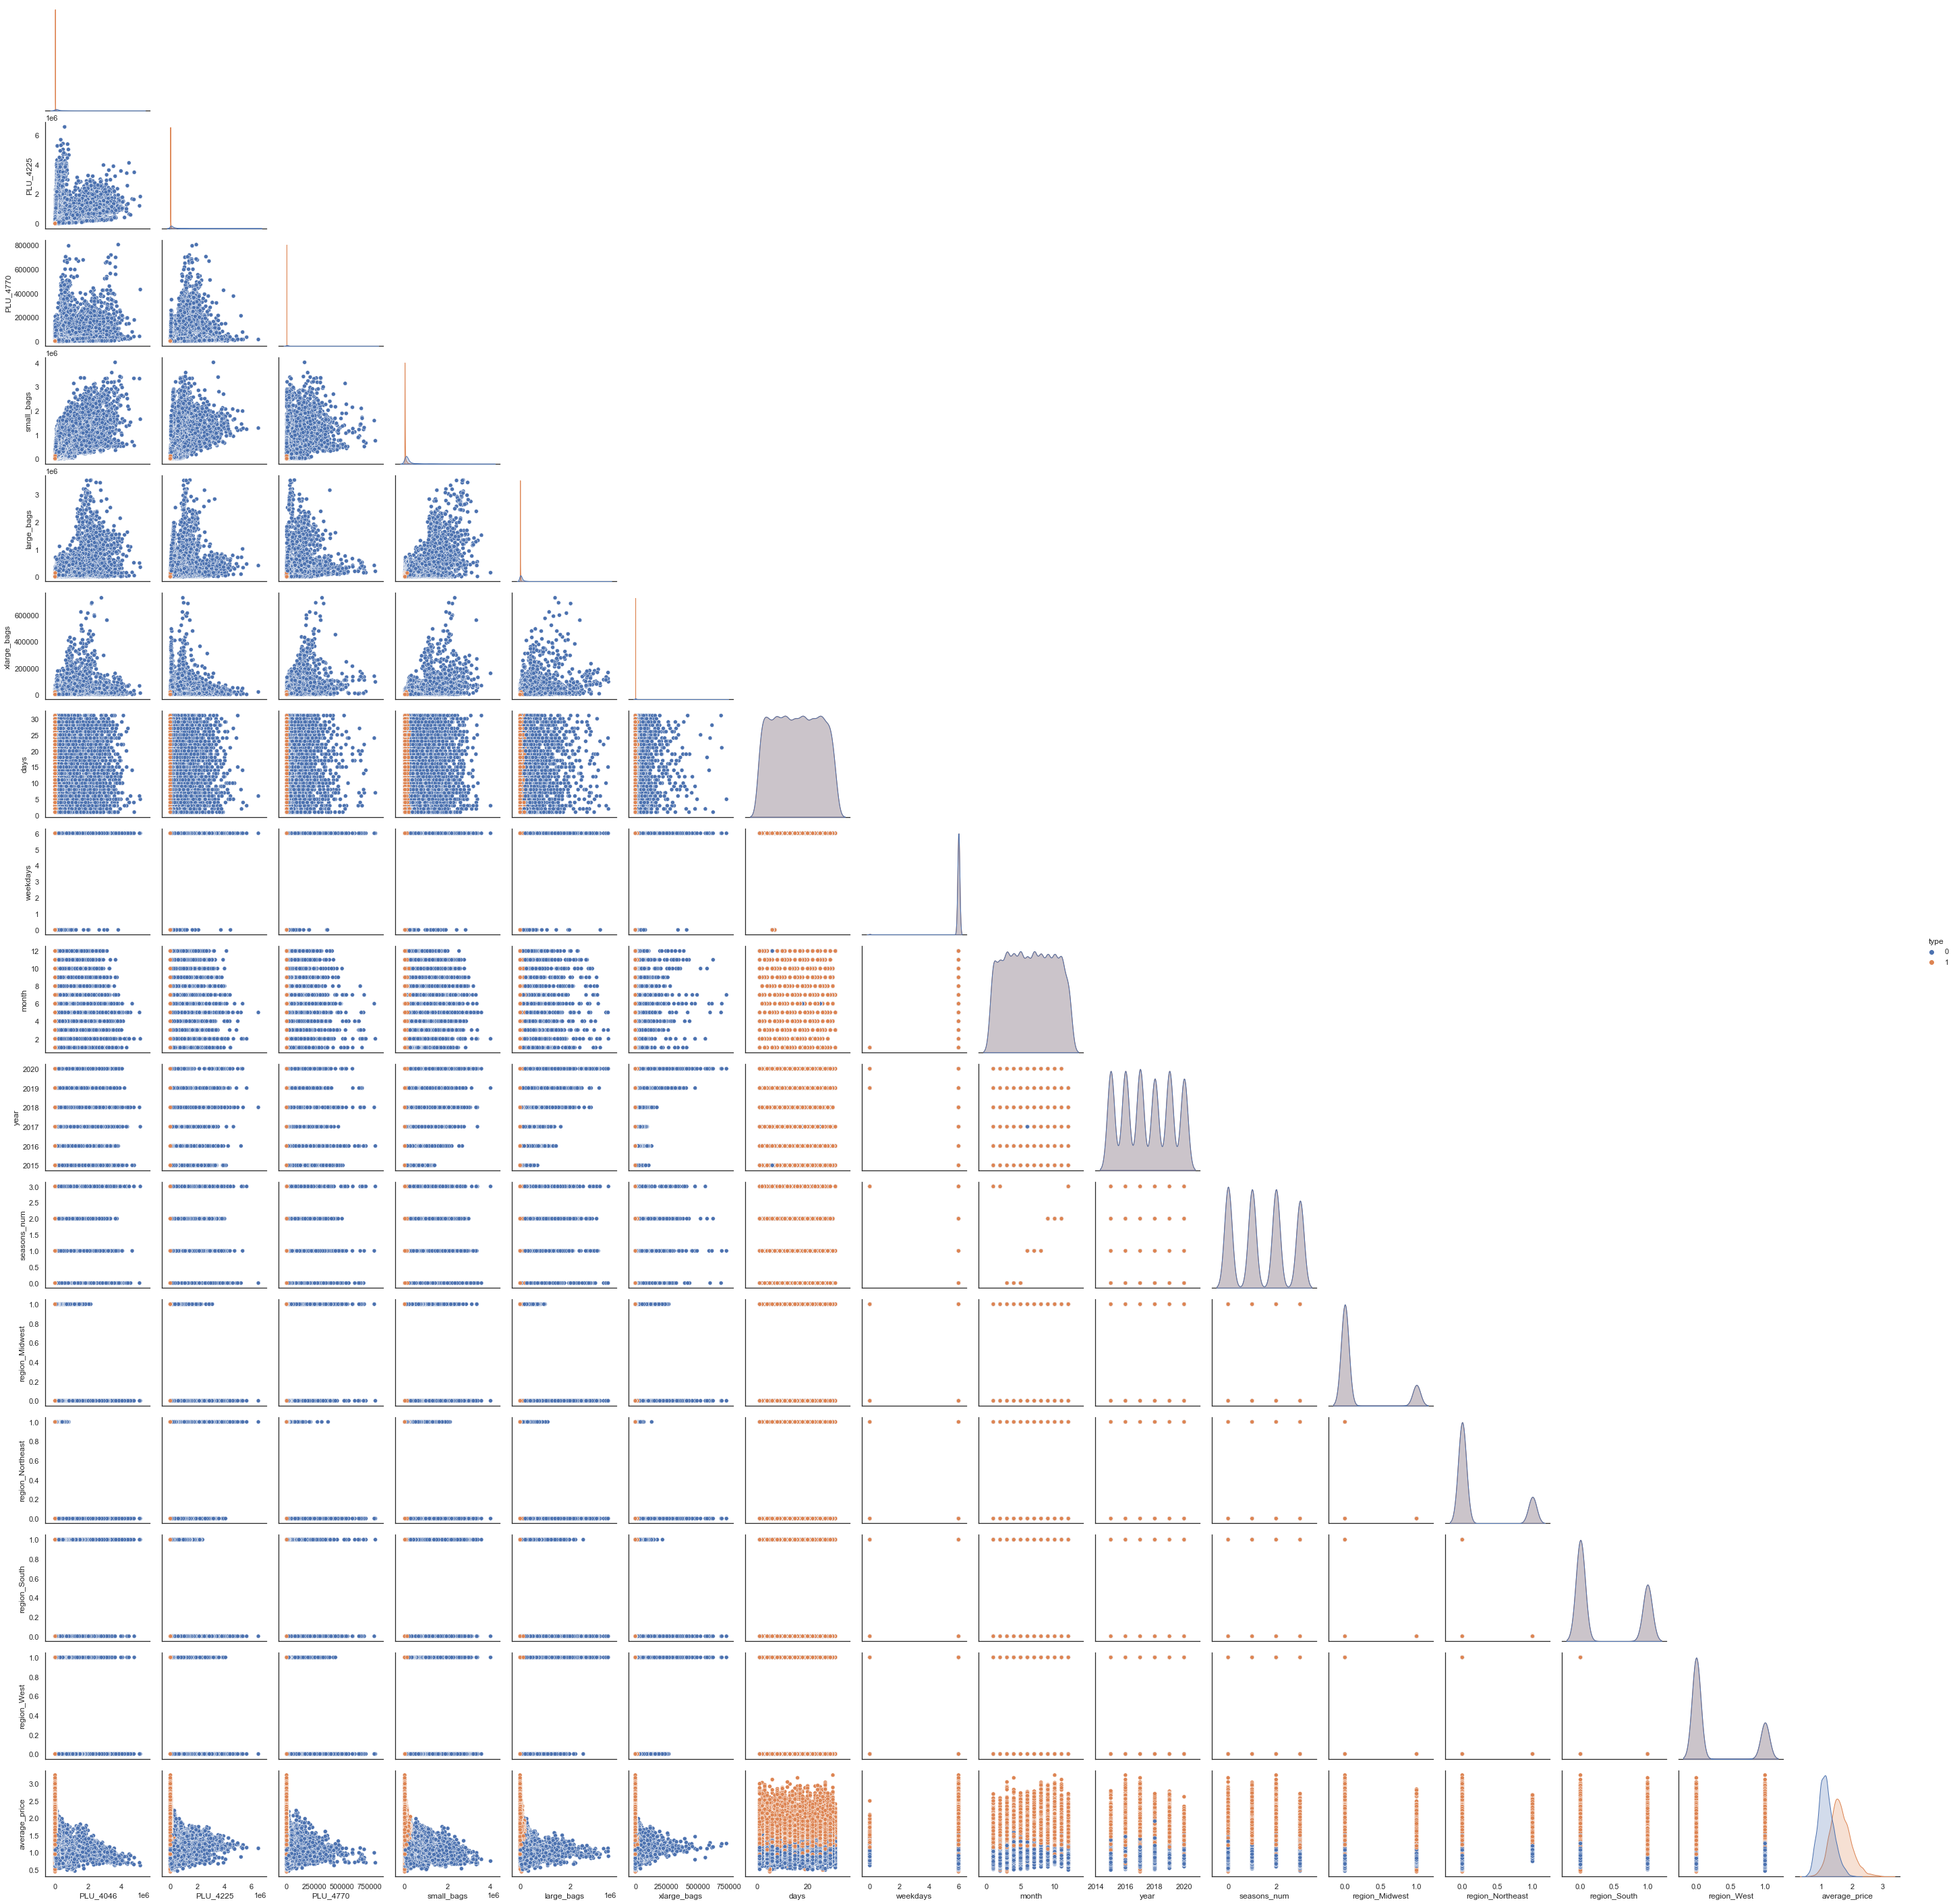

In [86]:
%%time
_ = sns.pairplot(df2, corner=True, hue='type')

## Model Selection

### Split Data (Features/Target, Train/Validation/Testing)

In [87]:
X = df2.drop(['average_price'], axis=1)
y = df2['average_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [88]:
X_train

PLU_4046    PLU_4225   PLU_4770  small_bags  large_bags  xlarge_bags  \
29247  3126689.77  1089439.68   54536.32  2227544.08  1446152.81     82305.59   
26670    13410.51    33170.71     317.22   132770.04    70718.44        61.49   
19005    17401.16    97654.08     102.24    21239.35     4413.26       613.33   
30878      174.56        0.00       0.00    10401.59      365.56         0.00   
2790   3656335.59  1416248.77   81756.00   678138.24   191572.72        52.33   
...           ...         ...        ...         ...         ...          ...   
30473    77862.28    16829.15    2762.62   185694.73     4385.12      2389.13   
5490     21127.59     3331.02       0.00    24355.90     3673.54         0.00   
876    3516551.29  2460932.41  170580.54   515386.40    34845.51      1838.10   
16093    78052.00   387453.00    3925.00   178913.00    10350.00         0.00   
24208       91.66     2776.65       0.00     1831.82     6268.49         0.00   

       days  weekdays  month  year  seasons_num  region_Midwest  \
29247    29         6      3  2020            0               0   
26670    13         6     10  2019            2               0   
19005    13         6      5  2018            0               0   
30878    12         6      7  2020            1               0   
2790     28         6      6  2015            1               0   
...     ...       ...    ...   ...          ...             ...   
30473    21         6      6  2020            1               1   
5490     20         6     12  2015            3               0   
876       1         6      3  2015            0               0   
16093    12         6     11  2017            2               0   
24208    12         6      5  2019            0               1   

       region_Northeast  region_South  region_West  type  
29247                 0             1            0     0  
26670                 0             0            1     1  
19005                 1             0            0     0  
30878                 0             1            0     1  
2790                  0             1            0     0  
...                 ...           ...          ...   ...  
30473                 0             0            0     0  
5490                  0             1            0     1  
876                   0             0            1     0  
16093                 0             0            1     0  
24208                 0             0            0     1  

[25860 rows x 16 columns]

In [89]:
X_test

PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
23388     104.01       0.00      0.00     8550.00        0.00         0.00   
28855  729944.60  144162.63   5157.33   518641.28   245819.12       230.27   
17669   33543.27   21090.24   1094.97    37660.14    23490.23         3.33   
14853    5632.85  242365.82   2441.56    22942.48    46083.51      3496.67   
24225  645852.47  242546.74   6274.45   196358.99   599106.39        44.88   
...          ...        ...       ...         ...         ...          ...   
18874    9072.35   10465.42      0.00    20394.01        4.44         0.00   
10464    2297.63     404.07      0.00      895.00     3715.77         0.00   
4173      361.95      30.88      0.00      385.24      373.57         0.00   
29312       0.00     676.03      0.00     3816.71     6281.29         0.00   
17138     563.16    3382.94    112.10    19899.04      677.62         0.00   

       days  weekdays  month  year  seasons_num  region_Midwest  \
23388    17         6      3  2019            0               0   
28855     8         6      3  2020            0               0   
17669    11         6      2  2018            3               0   
14853    20         6      8  2017            1               0   
24225    12         6      5  2019            0               0   
...     ...       ...    ...   ...          ...             ...   
18874    29         6      4  2018            0               0   
10464     6         6     11  2016            2               1   
4173     27         6      9  2015            2               0   
29312     5         6      4  2020            0               0   
17138     7         6      1  2018            3               0   

       region_Northeast  region_South  region_West  type  
23388                 0             1            0     1  
28855                 0             1            0     0  
17669                 1             0            0     0  
14853                 1             0            0     0  
24225                 0             1            0     0  
...                 ...           ...          ...   ...  
18874                 0             0            1     1  
10464                 0             0            0     1  
4173                  1             0            0     1  
29312                 0             1            0     1  
17138                 0             1            0     1  

[6466 rows x 16 columns]

#### Feature Scaling (Normalization/Standardization)

In [90]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train a Baseline Model using K-fold Cross Validation
### (start with Logistic Regression for Classification problems, Linear Regression for Regression problems)

In [91]:
%%time
lr_baseline = LinearRegression()
scores = cross_val_score(lr_baseline,
                         X_train_scaled,
                         y_train,
                         scoring='r2',
                         cv=5,
                         n_jobs=-1)

baseline_mean_score = scores.mean()
print("Baseline Model's score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))

Baseline Model's score: 0.46 (avg) 0.01 (std)
Wall time: 3.55 s


### Calculate R2 square for Multiple Models

In [92]:
# Consolidate all models' R2 score
model_scores = {"train" : [],"test" : []}

In [93]:
%%time
lr_regressor = LinearRegression()

# Train the model
lr_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = lr_regressor.predict(X_test_scaled)

# R2 score of test model to append
model_scores["train"].append(lr_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(lr_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('LinearRegression R2 square:',r2_score(y_test, y_pred))

LinearRegression R2 square: 0.46608447978816836
Wall time: 32.9 ms


In [94]:
# The coefficients
print('Coefficients: \n', lr_regressor.coef_)
# Train and Test score metrics
print('Train Score : {:.4f}'.format(lr_regressor.score(X_train_scaled, y_train)))
print('Test Score : {:.4f}'.format(lr_regressor.score(X_test_scaled, y_test)))

# note: in sklearn, model.score(X_test_scaled, y_test) is the same as r2_score(y_test, y_pred).

Coefficients: 
 [-0.04674736  0.01416657 -0.00508634 -0.00052456 -0.00908929  0.01850752
  0.01043862  0.00051842  0.045803   -0.02021816 -0.03042255 -0.01832554
  0.03879266 -0.03968323  0.02301775  0.22265183]
Train Score : 0.4603
Test Score : 0.4661


In [96]:
%%time
dt_regressor = DecisionTreeRegressor()

# Train the model
dt_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = dt_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(dt_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(dt_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('DecisionTreeRegressor R2 square:',r2_score(y_test, y_pred))

DecisionTreeRegressor R2 square: 0.7727520154573435
Wall time: 355 ms


In [97]:
%%time
rf_regressor = RandomForestRegressor()

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = rf_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(rf_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(rf_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('RandomForestRegressor R2 square:',r2_score(y_test, y_pred))

RandomForestRegressor R2 square: 0.8955901438098197
Wall time: 19.4 s


In [98]:
%%time
svm_regressor = SVR()

# Train the model
svm_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = svm_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(svm_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(svm_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('SupportVectorRegressor R2 square:',r2_score(y_test, y_pred))

SupportVectorRegressor R2 square: 0.6269879115655926
Wall time: 1min 47s


In [99]:
%%time
mlp_regressor = MLPRegressor()

# Train the model
mlp_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = mlp_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(mlp_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(mlp_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('MultiLayerPerceptronRegressor R2 square:',r2_score(y_test, y_pred))

MultiLayerPerceptronRegressor R2 square: 0.6552278516219863
Wall time: 10.7 s


In [100]:
%%time
knn_regressor = KNeighborsRegressor()

# Train the model
knn_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = knn_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(knn_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(knn_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('KNearestNeighborsRegressor R2 square:',r2_score(y_test, y_pred))

KNearestNeighborsRegressor R2 square: 0.6622358986341632
Wall time: 28.5 s


In [101]:
%%time
xgb_regressor = XGBRegressor()

# Train the model
xgb_regressor.fit(X_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = xgb_regressor.predict(X_test_scaled)

# R2 score of model to append
model_scores["train"].append(xgb_regressor.score(X_train_scaled, y_train))
model_scores["test"].append(xgb_regressor.score(X_test_scaled, y_test))

# Coefficient of determination metrics
print('eXtremeGradientBoostRegressor R2 square:',r2_score(y_test, y_pred))

eXtremeGradientBoostRegressor R2 square: 0.8673299201512662
Wall time: 1.96 s


In [102]:
model_scores

{'train': [0.460300346552013,
  1.0,
  0.9845038604497347,
  0.6339119472320565,
  0.6677056582762904,
  0.7771730124944233,
  0.925336050878252],
 'test': [0.46608447978816836,
  0.7727520154573435,
  0.8955901438098197,
  0.6269879115655926,
  0.6552278516219863,
  0.6622358986341632,
  0.8673299201512662]}

In [103]:
regressor_results = pd.DataFrame(data = model_scores, index = ["Linear Regression", "Decision Tree", "Random Forest", "Support Vector Machine", "MultiLayer Perceptron", "K-Nearest Neighbors", "XGradient Boost"])
models_r2 = ["Linear Regression", "Decision Tree", "Random Forest", "Support Vector Machine", "MultiLayer Perceptron", "K-Nearest Neighbors", "XGradient Boost"]

In [104]:
regressor_results

train      test
Linear Regression       0.460300  0.466084
Decision Tree           1.000000  0.772752
Random Forest           0.984504  0.895590
Support Vector Machine  0.633912  0.626988
MultiLayer Perceptron   0.667706  0.655228
K-Nearest Neighbors     0.777173  0.662236
XGradient Boost         0.925336  0.867330

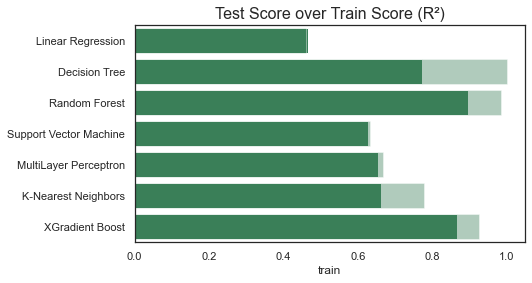

Wall time: 305 ms


In [105]:
%%time
plt.figure(figsize = (7, 4))
sns.barplot(data = regressor_results, x = "test", y = models_r2, color = "seagreen")
sns.barplot(data = regressor_results, x = "train", y = models_r2, color = "seagreen", alpha = 0.4)
plt.title("Test Score over Train Score (R²)", size = 16)
plt.show()

### Evaluate Multiple Models and Select Best Model

In [106]:
# prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('SVM', SVR()))
models.append(('DT', DecisionTreeRegressor(random_state=SEED)))
models.append(('RF', RandomForestRegressor(random_state=SEED)))
models.append(('MLP', MLPRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGB', XGBRegressor()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'

LR : Mean score 0.4596 (Std 0.0099)
SVM: Mean score 0.6191 (Std 0.0044)
DT : Mean score 0.7421 (Std 0.0130)
RF : Mean score 0.8804 (Std 0.0072)
MLP: Mean score 0.6511 (Std 0.0152)
KNN: Mean score 0.6399 (Std 0.0080)
XGB: Mean score 0.8645 (Std 0.0039)


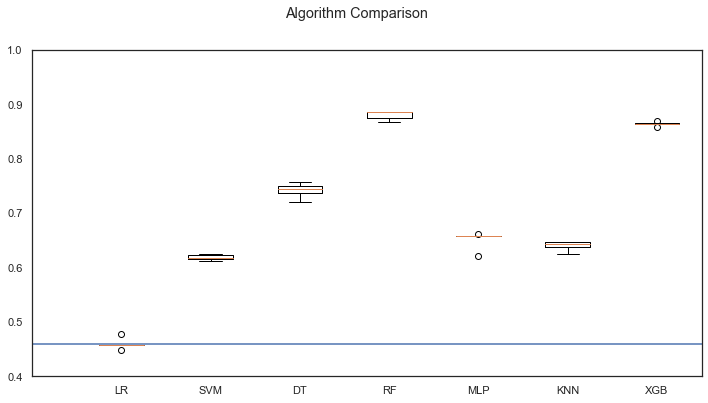

Wall time: 5min 6s


In [107]:
%%time
for name, model in models:
#     kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, 
                                 X_train_scaled, 
                                 y_train, 
                                 cv=5, 
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{:3}: Mean score {:.4f} (Std {:.4f})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.plot([-2,10], [baseline_mean_score, baseline_mean_score])
plt.xlim(0, 7.5)
plt.ylim(0.4, 1)
plt.show()

### Hyperparameter Fine-tuning for final selected model

In [108]:
%%time
# Hyperparameter fine-tuning for eXtremeGradientBoostRegressor on Regression dataset
parameters = {'n_estimators': [800, 900, 1000],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth' : [None, 9, 10, 11]}
    
gs_clf = GridSearchCV(XGBRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_xgbr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
0.9077553840637211
Wall time: 50min 37s


In [109]:
%%time
# Hyperparameter fine-tuning for Multi Layer Perceptron Neuro Network Regression on Regression dataset
parameters = {'hidden_layer_sizes': [(100,), (100, 100), (150), (300)],
              'alpha': np.logspace(-6, -2, 5)}
    
gs_clf = GridSearchCV(MLPRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_mlpr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
MLPRegressor(alpha=1e-05, hidden_layer_sizes=(100, 100), random_state=42)
{'alpha': 1e-05, 'hidden_layer_sizes': (100, 100)}
0.7181104111782307
Wall time: 12min 26s


In [110]:
%%time
# Hyperparameter fine-tuning for K Nearest Neighbors on Regression dataset
parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(2,10)}
    
gs_clf = GridSearchCV(KNeighborsRegressor(),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_knn = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNeighborsRegressor(n_neighbors=9, weights='distance')
{'n_neighbors': 9, 'weights': 'distance'}
0.6610971595749208
Wall time: 15min 29s


In [111]:
%%time
# Hyperparameter fine-tuning for Support Vector Machine on Regression dataset
parameters = {'kernel' : ['rbf'],
              'C':[0.1, 1, 5, 10],
              'gamma' : [0.5],
#               'degree': [3] # used for 'kernel' : ['linear', 'poly']
              }
    
gs_clf = GridSearchCV(SVR(epsilon=0.1),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_svr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVR(C=10, gamma=0.5)
{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.702758471906685
Wall time: 9min 43s


In [112]:
%%time
# Hyperparameter fine-tuning for Decision Tree on Regression dataset
parameters = {'criterion': ['mse'], 
              'max_depth': [None, 1, 2, 3, 4, 5, 6, 7],
              'min_samples_split': range(1, 10),
              'min_samples_leaf': range(1, 5)}
    
gs_clf = GridSearchCV(DecisionTreeRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_dtr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=9, random_state=42)
{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 9}
0.7714550642549766
Wall time: 26.4 s


In [113]:
%%time
# Hyperparameter fine-tuning for Random Forest on Regression dataset
parameters = {'n_estimators': [550, 600, 650],
#               'n_estimators': [300, 500, 700],
              'max_depth': [5, None],
              'min_samples_split': [2, 3, 5]}
#               'min_samples_leaf': [2, 3, 4],
#               'max_features': ['sqrt', 'log2']}
    
gs_clf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf_rfr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
RandomForestRegressor(n_estimators=600, random_state=42)
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 600}
0.882215129746944
Wall time: 30min 46s


### Evaluate the fine-tuned Model (whether it will generalize well with unseen data - testing dataset)

In [114]:
y_pred = final_clf_rfr.predict(X_test_scaled)

# train_score = gs_clf.score(X_train_scaled, y_train)
# test_score = gs_clf.score(X_test_scaled, y_test)
r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Final Model (Random Forest) Metrics -')
# print('\tTrained Score:', train_score)
# print('\tTested Score:', test_score)
print('\tR2 Score:', r2score)
print('\tMean Absolute Error:', mae)
print('\tMean Square Error:', mse)

Final Model (Random Forest) Metrics -
	R2 Score: 0.8964980774314879
	Mean Absolute Error: 0.08647496649139093
	Mean Square Error: 0.015004447514004891


In [115]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

compare_df

Desired Output (Actuals)  Predicted Output
23388                      1.16          1.158250
28855                      0.88          0.782067
17669                      1.22          1.222017
14853                      1.82          1.574967
24225                      0.83          0.775167
...                         ...               ...
18874                      1.73          1.781383
10464                      1.29          1.423400
4173                       1.47          1.491250
29312                      1.19          1.288517
17138                      1.18          1.319333

[6466 rows x 2 columns]

Wall time: 1.16 s


<Figure size 720x360 with 0 Axes>

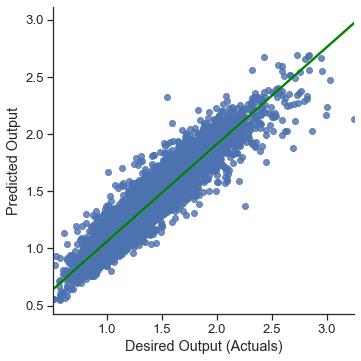

In [116]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

sns.lmplot(x="Desired Output (Actuals)",y="Predicted Output",data=compare_df,line_kws = {'color': 'green'},palette='pastel')

## Post-mortem Analysis

In [117]:
%%time
rf = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=SEED)
rf.fit(X_train_scaled, y_train)

Wall time: 4.24 s


RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [118]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

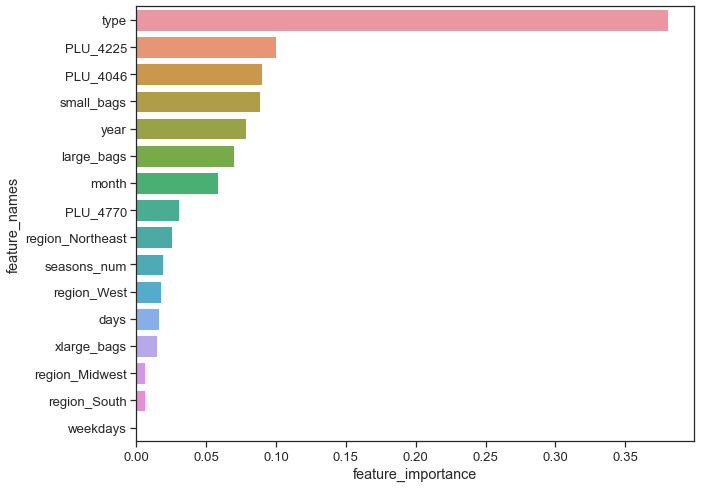

In [119]:
plt.figure(figsize=(10,8))
sns.set_color_codes("pastel")
_ = sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

## Feature Engineering

#### Rebuild the Model to reduce feature dimensiality to see if the new model improved while preserving the R2 score.

In [120]:
X2 = df2.drop(['average_price','days','weekdays','seasons_num','region_Midwest','region_Northeast','region_South','region_West'], axis=1)
y = df2['average_price']


X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=SEED)

In [121]:
X2_train

PLU_4046    PLU_4225   PLU_4770  small_bags  large_bags  xlarge_bags  \
29247  3126689.77  1089439.68   54536.32  2227544.08  1446152.81     82305.59   
26670    13410.51    33170.71     317.22   132770.04    70718.44        61.49   
19005    17401.16    97654.08     102.24    21239.35     4413.26       613.33   
30878      174.56        0.00       0.00    10401.59      365.56         0.00   
2790   3656335.59  1416248.77   81756.00   678138.24   191572.72        52.33   
...           ...         ...        ...         ...         ...          ...   
30473    77862.28    16829.15    2762.62   185694.73     4385.12      2389.13   
5490     21127.59     3331.02       0.00    24355.90     3673.54         0.00   
876    3516551.29  2460932.41  170580.54   515386.40    34845.51      1838.10   
16093    78052.00   387453.00    3925.00   178913.00    10350.00         0.00   
24208       91.66     2776.65       0.00     1831.82     6268.49         0.00   

       month  year  type  
29247      3  2020     0  
26670     10  2019     1  
19005      5  2018     0  
30878      7  2020     1  
2790       6  2015     0  
...      ...   ...   ...  
30473      6  2020     0  
5490      12  2015     1  
876        3  2015     0  
16093     11  2017     0  
24208      5  2019     1  

[25860 rows x 9 columns]

In [122]:
X2_test

PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
23388     104.01       0.00      0.00     8550.00        0.00         0.00   
28855  729944.60  144162.63   5157.33   518641.28   245819.12       230.27   
17669   33543.27   21090.24   1094.97    37660.14    23490.23         3.33   
14853    5632.85  242365.82   2441.56    22942.48    46083.51      3496.67   
24225  645852.47  242546.74   6274.45   196358.99   599106.39        44.88   
...          ...        ...       ...         ...         ...          ...   
18874    9072.35   10465.42      0.00    20394.01        4.44         0.00   
10464    2297.63     404.07      0.00      895.00     3715.77         0.00   
4173      361.95      30.88      0.00      385.24      373.57         0.00   
29312       0.00     676.03      0.00     3816.71     6281.29         0.00   
17138     563.16    3382.94    112.10    19899.04      677.62         0.00   

       month  year  type  
23388      3  2019     1  
28855      3  2020     0  
17669      2  2018     0  
14853      8  2017     0  
24225      5  2019     0  
...      ...   ...   ...  
18874      4  2018     1  
10464     11  2016     1  
4173       9  2015     1  
29312      4  2020     1  
17138      1  2018     1  

[6466 rows x 9 columns]

#### Feature Scaling (Normalization/Standardization)

In [123]:
scaler = StandardScaler()
scaler.fit(X2_train)
X2_train_scaled = scaler.transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

### Train and calculate R2 square

In [202]:
%%time
rf_regressor = RandomForestRegressor()

# Train the model
rf_regressor.fit(X2_train_scaled, y_train)

# Kept aside some data to test - X_test
y_pred = rf_regressor.predict(X2_test_scaled)

# Coefficient of determination metrics
print('RandomForestRegressor R2 square:',r2_score(y_test, y_pred))

RandomForestRegressor R2 square: 0.867745753159925
Wall time: 12.6 s


In [203]:
print("train score",rf_regressor.score(X2_train_scaled, y_train))
print("test score",rf_regressor.score(X2_test_scaled, y_test))

train score 0.9814412825133375
test score 0.867745753159925


In [204]:
%%time
# Hyperparameter fine-tuning for Random Forest on Regression dataset
parameters = {'n_estimators': [800, 900, 1000],
#               'n_estimators': [300, 500, 700],
              'max_depth': [5, None],
              'min_samples_split': [2, 3, 5]}
#               'min_samples_leaf': [2, 3, 4],
#               'max_features': ['sqrt', 'log2']}
    
gs_clf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1,
                     verbose = 2)
_ = gs_clf.fit(X2_train_scaled, y_train)

final_clf_rfr = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
RandomForestRegressor(min_samples_split=3, n_estimators=900, random_state=42)
{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 900}
0.8580263903867621
Wall time: 24min 27s


### Evaluate the fine-tuned Model (whether it will generalize well with unseen data - testing dataset)

In [205]:
y_pred = final_clf_rfr.predict(X2_test_scaled)

# train_score = gs_clf.score(X_train_scaled, y_train)
# test_score = gs_clf.score(X_test_scaled, y_test)
r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Final Model (Random Forest) Metrics -')
# print('\tTrained Score:', train_score)
# print('\tTested Score:', test_score)
print('\tR2 Score:', r2score)
print('\tMean Absolute Error:', mae)
print('\tMean Square Error:', mse)

Final Model (Random Forest) Metrics -
	R2 Score: 0.8683657058855447
	Mean Absolute Error: 0.09602745488285337
	Mean Square Error: 0.01908273593445599


In [206]:
compare_df1 = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

compare_df1

Desired Output (Actuals)  Predicted Output
23388                      1.16          1.162054
28855                      0.88          0.772955
17669                      1.22          1.179716
14853                      1.82          1.569080
24225                      0.83          0.753424
...                         ...               ...
18874                      1.73          1.709248
10464                      1.29          1.432840
4173                       1.47          1.493950
29312                      1.19          1.394005
17138                      1.18          1.396169

[6466 rows x 2 columns]

Wall time: 871 ms


<Figure size 720x360 with 0 Axes>

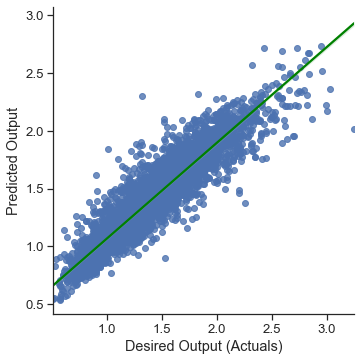

In [207]:
%%time
plt.figure(figsize=(10, 5))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

sns.lmplot(x="Desired Output (Actuals)",y="Predicted Output",data=compare_df1,line_kws = {'color': 'green'},palette='pastel')

## Predict Average Price in the next years

#### Rebuild a simple Linear Model by Avocado Type to predict future avocado price

In [129]:
df2

PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
0         2819.50   28287.42     49.90     9186.93      529.53         0.00   
1           57.42     153.88      0.00     1162.65        0.00         0.00   
2       364302.39   23821.16     82.15    16707.15    30108.64         0.00   
3         1500.15     938.35      0.00     1071.35      336.84         0.00   
4        53987.31  552906.04  39995.03   137146.07     3990.61         0.00   
...           ...        ...       ...         ...         ...          ...   
33038      101.71       0.00      0.00    11782.17        0.00         0.00   
33041  1352877.53  589061.83  19741.90  2197611.02  1531530.14     61524.13   
33042    13273.75   19341.09    636.51   122606.21   134103.71         0.00   
33043   234688.01   80205.15  10543.63   285764.11   210808.02       809.83   
33044     1236.96     617.80   1564.98    17824.52     2862.32         0.00   

       days  weekdays  month  year  seasons_num  region_Midwest  \
0         4         6      1  2015            3               0   
1         4         6      1  2015            3               0   
2         4         6      1  2015            3               0   
3         4         6      1  2015            3               0   
4         4         6      1  2015            3               0   
...     ...       ...    ...   ...          ...             ...   
33038    29         6     11  2020            2               0   
33041    29         6     11  2020            2               0   
33042    29         6     11  2020            2               0   
33043    29         6     11  2020            2               0   
33044    29         6     11  2020            2               0   

       region_Northeast  region_South  region_West  type  average_price  
0                     1             0            0     0           1.22  
1                     1             0            0     1           1.79  
2                     0             1            0     0           1.00  
3                     0             1            0     1           1.76  
4                     0             0            1     0           1.08  
...                 ...           ...          ...   ...            ...  
33038                 0             1            0     1           0.95  
33041                 0             0            1     0           0.91  
33042                 0             0            1     1           1.48  
33043                 0             1            0     0           0.67  
33044                 0             1            0     1           1.35  

[32326 rows x 17 columns]

In [130]:
total_avocado

[6120438306, 5777784087, 442456504, 5142922894, 2197789194, 159261591]

#### Across all US regions

In [131]:
# Across all US regions
df2_conventional = df2.loc[df1['type'] == 'conventional']
df2_organic = df2.loc[df1['type'] == 'organic']

In [132]:
df2_conventional

PLU_4046   PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
0         2819.50   28287.42     49.90     9186.93      529.53         0.00   
2       364302.39   23821.16     82.15    16707.15    30108.64         0.00   
4        53987.31  552906.04  39995.03   137146.07     3990.61         0.00   
6        44562.12   24964.23   2752.35     6064.30     1691.32         0.00   
8         7193.87  396752.18    128.82    87406.84      256.29         0.00   
...           ...        ...       ...         ...         ...          ...   
33033    78597.67    9497.22     65.16    93625.26     7402.27         0.00   
33035     6789.51   31201.09    627.87    20587.54    11866.23      1056.67   
33037   230468.94   15289.83     44.60   251658.97    64927.71        47.30   
33041  1352877.53  589061.83  19741.90  2197611.02  1531530.14     61524.13   
33043   234688.01   80205.15  10543.63   285764.11   210808.02       809.83   

       days  weekdays  month  year  seasons_num  region_Midwest  \
0         4         6      1  2015            3               0   
2         4         6      1  2015            3               0   
4         4         6      1  2015            3               0   
6         4         6      1  2015            3               0   
8         4         6      1  2015            3               0   
...     ...       ...    ...   ...          ...             ...   
33033    29         6     11  2020            2               1   
33035    29         6     11  2020            2               0   
33037    29         6     11  2020            2               0   
33041    29         6     11  2020            2               0   
33043    29         6     11  2020            2               0   

       region_Northeast  region_South  region_West  type  average_price  
0                     1             0            0     0           1.22  
2                     0             1            0     0           1.00  
4                     0             0            1     0           1.08  
6                     0             0            1     0           1.01  
8                     1             0            0     0           1.02  
...                 ...           ...          ...   ...            ...  
33033                 0             0            0     0           0.83  
33035                 1             0            0     0           0.95  
33037                 0             1            0     0           0.65  
33041                 0             0            1     0           0.91  
33043                 0             1            0     0           0.67  

[16165 rows x 17 columns]

In [133]:
df2_organic

PLU_4046  PLU_4225  PLU_4770  small_bags  large_bags  xlarge_bags  \
1         57.42    153.88      0.00     1162.65        0.00          0.0   
3       1500.15    938.35      0.00     1071.35      336.84          0.0   
5       8040.64   6557.47    657.48     3881.69        0.00          0.0   
7          1.27   1129.50      0.00      186.67      187.68          0.0   
9          8.66    939.43      0.00     1244.04        0.00          0.0   
...         ...       ...       ...         ...         ...          ...   
33034    677.71    912.70      0.00     4301.25        6.67          0.0   
33036    166.36     89.78      0.00     2618.57      316.88          0.0   
33038    101.71      0.00      0.00    11782.17        0.00          0.0   
33042  13273.75  19341.09    636.51   122606.21   134103.71          0.0   
33044   1236.96    617.80   1564.98    17824.52     2862.32          0.0   

       days  weekdays  month  year  seasons_num  region_Midwest  \
1         4         6      1  2015            3               0   
3         4         6      1  2015            3               0   
5         4         6      1  2015            3               0   
7         4         6      1  2015            3               0   
9         4         6      1  2015            3               0   
...     ...       ...    ...   ...          ...             ...   
33034    29         6     11  2020            2               1   
33036    29         6     11  2020            2               0   
33038    29         6     11  2020            2               0   
33042    29         6     11  2020            2               0   
33044    29         6     11  2020            2               0   

       region_Northeast  region_South  region_West  type  average_price  
1                     1             0            0     1           1.79  
3                     0             1            0     1           1.76  
5                     0             0            1     1           1.29  
7                     0             0            1     1           1.64  
9                     1             0            0     1           1.83  
...                 ...           ...          ...   ...            ...  
33034                 0             0            0     1           1.84  
33036                 1             0            0     1           1.46  
33038                 0             1            0     1           0.95  
33042                 0             0            1     1           1.48  
33044                 0             1            0     1           1.35  

[16161 rows x 17 columns]

Predicted avocado prices (Conventional) in 2021 is: US$ 1.145067


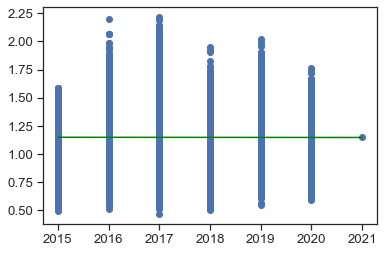

Wall time: 500 ms


In [134]:
%%time
# Conventional Avocado price prediction


X_linear = df2_conventional['year'].reset_index(drop=True).copy()
y_linear = df2_conventional['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted avocado prices (Conventional) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()

Predicted avocado prices (Organic) in 2021 is: US$ 1.531426


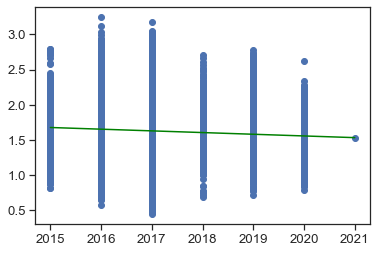

Wall time: 314 ms


In [135]:
%%time
# Conventional Avocado price prediction


X_linear = df2_organic['year'].reset_index(drop=True).copy()
y_linear = df2_organic['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted avocado prices (Organic) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()

#### Across San Francisco

In [136]:
# Across San Francisco
df2_organic_sf = df1[df1['geography'] == 'San Francisco'].drop(['geography'], axis=1)
df2_organic_sf = df2_organic_sf[df1['type'] == 'organic']

df2_conventional_sf = df1[df1['geography'] == 'San Francisco'].drop(['geography'], axis=1)
df2_conventional_sf = df2_conventional_sf[df1['type'] == 'conventional']

In [137]:
df2_conventional_sf

date  average_price  total_volume   PLU_4046   PLU_4225  PLU_4770  \
84    2015-01-04           0.99     907795.89  179507.69  637000.10   8803.79   
192   2015-01-11           1.03     916450.76  155455.32  670522.75   4107.26   
300   2015-01-18           1.22     753746.51  107566.95  554501.21  12868.74   
408   2015-01-25           1.21     713523.24  127276.45  481792.41  21293.67   
516   2015-02-01           0.91    1352027.64  369580.89  896514.30  20587.92   
...          ...            ...           ...        ...        ...       ...   
32589 2020-11-01           1.34     809918.36  132210.15  223873.68   6995.27   
32697 2020-11-08           1.00    1019657.74  196477.34  203430.68   6664.93   
32805 2020-11-15           1.28     890786.67  207076.19  232015.65   5364.41   
32913 2020-11-22           1.28     778476.27  156625.29  167370.28   4767.84   
33021 2020-11-29           1.50     644141.37  128555.43  136718.24   5597.21   

       total_bags  small_bags  large_bags  xlarge_bags          type  year  \
84       82484.31    82033.71      444.44         6.16  conventional  2015   
192      86365.43    85706.54      658.89         0.00  conventional  2015   
300      78809.61    78241.87      515.56        52.18  conventional  2015   
408      83160.71    82293.47      796.67        70.57  conventional  2015   
516      65344.53    64393.44      832.23       118.86  conventional  2015   
...           ...         ...         ...          ...           ...   ...   
32589   446839.26   175862.93   221233.31     49743.02  conventional  2020   
32697   613084.79   194561.80   411810.78      6712.21  conventional  2020   
32805   446330.42   229568.82   213044.82      3716.78  conventional  2020   
32913   449712.86   187499.75   257065.31      5147.80  conventional  2020   
33021   373270.49   159276.65   207760.32      6233.52  conventional  2020   

       month  seasons_num seasons  days  weekdays day_names division region  
84         1            3  winter     4         6    Sunday  Pacific   West  
192        1            3  winter    11         6    Sunday  Pacific   West  
300        1            3  winter    18         6    Sunday  Pacific   West  
408        1            3  winter    25         6    Sunday  Pacific   West  
516        2            3  winter     1         6    Sunday  Pacific   West  
...      ...          ...     ...   ...       ...       ...      ...    ...  
32589     11            2    fall     1         6    Sunday  Pacific   West  
32697     11            2    fall     8         6    Sunday  Pacific   West  
32805     11            2    fall    15         6    Sunday  Pacific   West  
32913     11            2    fall    22         6    Sunday  Pacific   West  
33021     11            2    fall    29         6    Sunday  Pacific   West  

[305 rows x 20 columns]

In [138]:
df2_organic_sf

date  average_price  total_volume  PLU_4046  PLU_4225  PLU_4770  \
85    2015-01-04           1.18      22630.58  13175.57   9028.34      0.00   
193   2015-01-11           1.12      29676.78  17907.49  11586.46      0.00   
301   2015-01-18           1.27      41482.48  26336.41  14789.40      0.00   
409   2015-01-25           1.34      27146.81  17038.27   9879.87      0.00   
517   2015-02-01           1.06      57802.02  38413.44  19160.87      0.00   
...          ...            ...           ...       ...       ...       ...   
32590 2020-11-01           1.36     157108.59   3376.51  91678.09     17.19   
32698 2020-11-08           1.60      85145.79   2996.19  22776.11      1.43   
32806 2020-11-15           1.78      61454.10   4727.34   5548.32      0.00   
32914 2020-11-22           1.87      59882.68   3110.05   4956.81      4.17   
33022 2020-11-29           1.87      59527.02   2815.23   4542.30      0.00   

       total_bags  small_bags  large_bags  xlarge_bags     type  year  month  \
85         426.67      426.67        0.00          0.0  organic  2015      1   
193        182.83      182.83        0.00          0.0  organic  2015      1   
301        356.67      356.67        0.00          0.0  organic  2015      1   
409        228.67      228.67        0.00          0.0  organic  2015      1   
517        227.71      227.71        0.00          0.0  organic  2015      2   
...           ...         ...         ...          ...      ...   ...    ...   
32590    62036.80    61809.25      227.55          0.0  organic  2020     11   
32698    59372.06    59275.19       96.87          0.0  organic  2020     11   
32806    51178.44    51088.34       90.10          0.0  organic  2020     11   
32914    51811.65    51680.30      131.35          0.0  organic  2020     11   
33022    52169.49    52034.33      135.16          0.0  organic  2020     11   

       seasons_num seasons  days  weekdays day_names division region  
85               3  winter     4         6    Sunday  Pacific   West  
193              3  winter    11         6    Sunday  Pacific   West  
301              3  winter    18         6    Sunday  Pacific   West  
409              3  winter    25         6    Sunday  Pacific   West  
517              3  winter     1         6    Sunday  Pacific   West  
...            ...     ...   ...       ...       ...      ...    ...  
32590            2    fall     1         6    Sunday  Pacific   West  
32698            2    fall     8         6    Sunday  Pacific   West  
32806            2    fall    15         6    Sunday  Pacific   West  
32914            2    fall    22         6    Sunday  Pacific   West  
33022            2    fall    29         6    Sunday  Pacific   West  

[305 rows x 20 columns]

Predicted San Francisco avocado prices (Conventional) in 2021 is: US$ 1.439132


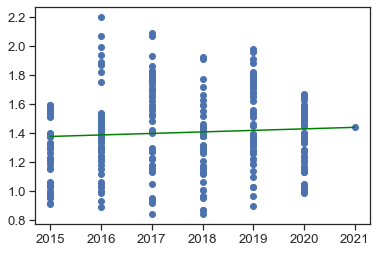

Wall time: 267 ms


In [139]:
%%time
# Conventional Avocado price prediction


X_linear = df2_conventional_sf['year'].reset_index(drop=True).copy()
y_linear = df2_conventional_sf['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted San Francisco avocado prices (Conventional) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()

Predicted San Francisco avocado prices (Organic) in 2021 is: US$ 2.001696


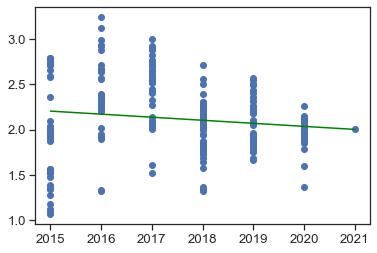

Wall time: 177 ms


In [140]:
%%time
# Conventional Avocado price prediction


X_linear = df2_organic_sf['year'].reset_index(drop=True).copy()
y_linear = df2_organic_sf['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted San Francisco avocado prices (Organic) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()

#### Across Houston

In [141]:
# Across Houston
df2_organic_h = df1[df1['geography'] == 'Houston'].drop(['geography'], axis=1)
df2_organic_h = df2_organic_h[df1['type'] == 'organic']

df2_conventional_h = df1[df1['geography'] == 'Houston'].drop(['geography'], axis=1)
df2_conventional_h = df2_conventional_h[df1['type'] == 'conventional']

In [142]:
df2_conventional_h

date  average_price  total_volume   PLU_4046   PLU_4225  PLU_4770  \
36    2015-01-04           0.71    1062990.62  506426.58  436347.57   4378.92   
144   2015-01-11           0.78    1062071.65  463272.52  441785.80   4094.47   
252   2015-01-18           0.77    1017854.16  458532.19  429687.47   9353.74   
360   2015-01-25           0.77     983910.94  549415.32  309974.97   4231.47   
468   2015-02-01           0.72    1280364.01  540024.17  597855.73   8063.40   
...          ...            ...           ...        ...        ...       ...   
32541 2020-11-01           0.67    1685310.33  478780.10  308814.75   2748.49   
32649 2020-11-08           0.69    1584942.64  456257.32  303393.93   2299.80   
32757 2020-11-15           0.64    1776506.50  539375.58  350673.22   2656.26   
32865 2020-11-22           0.63    1397611.45  477201.00  294708.57   2632.82   
32973 2020-11-29           0.66    1263472.92  500722.30  186180.93   2864.49   

       total_bags  small_bags  large_bags  xlarge_bags          type  year  \
36      115837.55    90299.85    25537.70         0.00  conventional  2015   
144     152918.86   126995.76    25923.10         0.00  conventional  2015   
252     120280.76   107320.39    12960.37         0.00  conventional  2015   
360     120289.18    95546.28    24742.90         0.00  conventional  2015   
468     134420.71    86145.18    48275.53         0.00  conventional  2015   
...           ...         ...         ...          ...           ...   ...   
32541   894966.99   329134.26   547307.90     18524.83  conventional  2020   
32649   822991.59   329580.44   475120.62     18290.53  conventional  2020   
32757   883801.44   353639.97   510306.33     19855.14  conventional  2020   
32865   623069.06   327254.01   276353.81     19461.24  conventional  2020   
32973   573705.20   314839.82   244312.82     14552.56  conventional  2020   

       month  seasons_num seasons  days  weekdays day_names  \
36         1            3  winter     4         6    Sunday   
144        1            3  winter    11         6    Sunday   
252        1            3  winter    18         6    Sunday   
360        1            3  winter    25         6    Sunday   
468        2            3  winter     1         6    Sunday   
...      ...          ...     ...   ...       ...       ...   
32541     11            2    fall     1         6    Sunday   
32649     11            2    fall     8         6    Sunday   
32757     11            2    fall    15         6    Sunday   
32865     11            2    fall    22         6    Sunday   
32973     11            2    fall    29         6    Sunday   

                 division region  
36     West South Central  South  
144    West South Central  South  
252    West South Central  South  
360    West South Central  South  
468    West South Central  South  
...                   ...    ...  
32541  West South Central  South  
32649  West South Central  South  
32757  West South Central  South  
32865  West South Central  South  
32973  West South Central  South  

[305 rows x 20 columns]

In [143]:
df2_organic_h

date  average_price  total_volume  PLU_4046  PLU_4225  PLU_4770  \
37    2015-01-04           1.22       8938.32   7009.77    671.88       0.0   
145   2015-01-11           1.26       7561.00   6142.35    818.65       0.0   
253   2015-01-18           1.20       9979.64   8538.96    690.68       0.0   
361   2015-01-25           1.24      11398.91   9698.27    893.97       0.0   
469   2015-02-01           1.15      12285.76   9833.51   1505.58       0.0   
...          ...            ...           ...       ...       ...       ...   
32542 2020-11-01           1.19      29179.74   3835.84      0.00       0.0   
32650 2020-11-08           1.19      26848.39   3695.33      0.00       0.0   
32758 2020-11-15           1.18      25786.91   4737.95      0.00       0.0   
32866 2020-11-22           1.18      24834.46   4087.07      0.00       0.0   
32974 2020-11-29           1.29      24312.04   3008.52      0.00       0.0   

       total_bags  small_bags  large_bags  xlarge_bags     type  year  month  \
37        1256.67     1256.67        0.00          0.0  organic  2015      1   
145        600.00      600.00        0.00          0.0  organic  2015      1   
253        750.00      750.00        0.00          0.0  organic  2015      1   
361        806.67      806.67        0.00          0.0  organic  2015      1   
469        946.67      946.67        0.00          0.0  organic  2015      2   
...           ...         ...         ...          ...      ...   ...    ...   
32542    25343.90    13353.91    11989.99          0.0  organic  2020     11   
32650    23153.06    12358.34    10794.72          0.0  organic  2020     11   
32758    21048.96    10638.80    10410.16          0.0  organic  2020     11   
32866    20747.39    10881.33     9866.06          0.0  organic  2020     11   
32974    21303.52    11000.49    10303.03          0.0  organic  2020     11   

       seasons_num seasons  days  weekdays day_names            division  \
37               3  winter     4         6    Sunday  West South Central   
145              3  winter    11         6    Sunday  West South Central   
253              3  winter    18         6    Sunday  West South Central   
361              3  winter    25         6    Sunday  West South Central   
469              3  winter     1         6    Sunday  West South Central   
...            ...     ...   ...       ...       ...                 ...   
32542            2    fall     1         6    Sunday  West South Central   
32650            2    fall     8         6    Sunday  West South Central   
32758            2    fall    15         6    Sunday  West South Central   
32866            2    fall    22         6    Sunday  West South Central   
32974            2    fall    29         6    Sunday  West South Central   

      region  
37     South  
145    South  
253    South  
361    South  
469    South  
...      ...  
32542  South  
32650  South  
32758  South  
32866  South  
32974  South  

[305 rows x 20 columns]

Predicted Houston avocado prices (Conventional) in 2021 is: US$ 0.788843


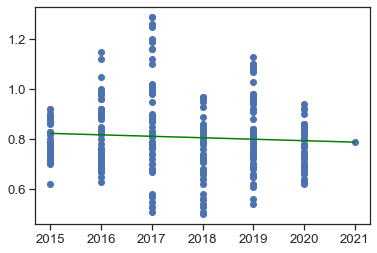

Wall time: 202 ms


In [144]:
%%time
# Conventional Avocado price prediction


X_linear = df2_conventional_h['year'].reset_index(drop=True).copy()
y_linear = df2_conventional_h['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted Houston avocado prices (Conventional) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()

Predicted Houston avocado prices (Organic) in 2021 is: US$ 1.501071


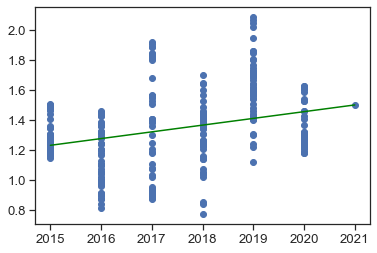

Wall time: 196 ms


In [145]:
%%time
# Conventional Avocado price prediction


X_linear = df2_organic_h['year'].reset_index(drop=True).copy()
y_linear = df2_organic_h['average_price'].reset_index(drop=True).copy()


slope, intercept, r, p, std_err = stats.linregress(X_linear, y_linear) # scipy

def prediction(x):
    return slope * x + intercept

name = 'Average Avocado price in 2021'
md = list(map(prediction, X_linear)) # scipy

X_pred_linear = 2021
y_pred_linear = prediction(X_pred_linear)

print('Predicted Houston avocado prices (Organic) in 2021 is: US$ %f' % y_pred_linear)

X_linear2 = X_linear.append(pd.Series(X_pred_linear))
y_linear2 = y_linear.append(pd.Series(y_pred_linear))
md2 = list(map(prediction, X_linear2)) 

plt.scatter(X_linear2, y_linear2) # Scatter Plot
plt.plot(X_linear2, md2, color='green')
plt.xticks(np.arange(min(X_linear2), max(X_linear2+1), 1.0))
plt.show()

#plt.ylim(ymin=0) # starts at zero
#plt.legend(['Model Prediction using Linear Regression', 'Avocado Prices (2015-2018)'])
#plt.show()